In [311]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# Data Preprocessing

In [312]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  I_KOMP1_SAAT  I_KOMP2_HIZ  \
0     2023-04-01 00:00:00  1.593893    25.000000        8968.0          0.0   
1     2023-04-01 00:05:00  1.623764    45.200001        8968.0          0.0   
2     2023-04-01 00:10:00  1.634981    25.700001        8968.0          0.0   
3     2023-04-01 00:15:00  1.608970    28.400000        8968.0          0.0   
4     2023-04-01 00:20:00  1.554008    28.000000        8968.0          0.0   
...                   ...       ...          ...           ...          ...   
59625 2023-10-25 00:45:00  1.611181    26.400000       13761.0          0.0   
59626 2023-10-25 00:50:00  1.831158    39.200001       13761.0          0.0   
59627 2023-10-25 00:55:00  1.627907    44.000000       13761.0          0.0   
59628 2023-10-25 01:00:00  1.590126     0.000000       13761.0          0.0   
59629 2023-10-25 01:05:00  1.773319    55.700001       13761.0          0.0   

       I_KOMP2_SAAT  I_NEM_SET  I_SIC_SET  II_KOMP1_HIZ  II_KOMP1_SAAT  ...  \
0               3.0       45.0       23.0     36.200001        12770.0  ...   
1               3.0       45.0       23.0     34.000000        12770.0  ...   
2               3.0       45.0       23.0     34.700001        12770.0  ...   
3               3.0       45.0       23.0     39.900002        12770.0  ...   
4               3.0       45.0       23.0     36.900002        12770.0  ...   
...             ...        ...        ...           ...            ...  ...   
59625           3.0       45.0       22.0      0.000000        17241.0  ...   
59626           3.0       45.0       22.0     49.700001        17241.0  ...   
59627           3.0       45.0       22.0      0.000000        17241.0  ...   
59628           3.0       45.0       22.0     29.400000        17241.0  ...   
59629           3.0       45.0       22.0      0.000000        17241.0  ...   

       month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0            0        0        1        0        0        0        0        0   
1            0        0        1        0        0        0        0        0   
2            0        0        1        0        0        0        0        0   
3            0        0        1        0        0        0        0        0   
4            0        0        1        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
59625        0        0        0        0        0        0        0        0   
59626        0        0        0        0        0        0        0        0   
59627        0        0        0        0        0        0        0        0   
59628        0        0        0        0        0        0        0        0   
59629        0        0        0        0        0        0        0        0   

       month_10  month_11  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
...         ...       ...  
59625         1         0  
59626         1         0  
59627         1         0  
59628         1         0  
59629         1         0  

[59630 rows x 76 columns]

In [313]:
## PUE detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] > 2.5) | (FINAL_DF['PUE'] < 1)]

## REPLACE OUTLIERS WITH THE MEAN OF THE ADJACENT VALUES
for i in outliers.index:
    if i == 0:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i + 1, 'PUE']
    elif i == len(FINAL_DF) - 1:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i - 1, 'PUE']
    else:
        FINAL_DF.loc[i, 'PUE'] = (FINAL_DF.loc[i - 1, 'PUE'] + FINAL_DF.loc[i + 1, 'PUE']) / 2


In [314]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
HOURS = ['hour_' + str(hour) for hour in range(24)]
MONTHS = ['month_' + str(month) for month in range(4, 11)]
column_names = ['Timestamp', 'PUE',
                    
                    'I_KOMP1_HIZ', 
                    #'I_KOMP1_SAAT',
                    #'I_KOMP2_HIZ', 
                    #'I_KOMP2_SAAT',
                    #'I_NEM_SET','I_SIC_SET', 
                    
                    'II_KOMP1_HIZ', 
                    #'II_KOMP1_SAAT',
                    #'II_KOMP2_HIZ',
                    #'II_KOMP2_SAAT',
                    #'II_NEM_SET','II_SIC_SET', 
                    
                    'III_KOMP1_HIZ', 
                    #'III_KOMP1_SAAT',
                    #'III_KOMP2_HIZ', 
                    #'III_KOMP2_SAAT',
                    #'III_NEM_SET','III_SIC_SET', 
                    
                    'IV_KOMP1_HIZ', 
                    #'IV_KOMP1_SAAT',
                    #'IV_KOMP2_HIZ', 
                    #'IV_KOMP2_SAAT',
                    #'IV_NEM_SET',
                    
                    'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC',
                    'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC', 
                    'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
                    
                    'SENSOR_I_TEMP', 'SENSOR_II_TEMP', 
                    'OUTLET_TEMP', 'OUTLET_HUMIDITY'] + DAYS + HOURS + MONTHS

In [315]:
FINAL_DF = FINAL_DF.loc[:, column_names]

In [316]:
# add extra columns

#FINAL_DF["PUE_lag_" + str(1)] = FINAL_DF["PUE"].shift(1)
FINAL_DF["PUE_lag_one_day"] = FINAL_DF["PUE"].shift(24*12)
#FINAL_DF["PUE_lag_one_week"] = FINAL_DF["PUE"].shift(7*24*12)


FINAL_DF.dropna(inplace=True)
FINAL_DF.reset_index(drop=True, inplace=True)
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  II_KOMP1_HIZ  III_KOMP1_HIZ  \
0     2023-04-02 00:00:00  1.576731    25.000000     40.000000      64.000000   
1     2023-04-02 00:05:00  1.621673    25.700001     36.200001      61.700001   
2     2023-04-02 00:10:00  1.645333    31.000000     27.200001      63.900002   
3     2023-04-02 00:15:00  1.603257    29.500000     30.200001      39.900002   
4     2023-04-02 00:20:00  1.588868    37.500000     35.799999      45.900002   
...                   ...       ...          ...           ...            ...   
59337 2023-10-25 00:45:00  1.611181    26.400000      0.000000      39.200001   
59338 2023-10-25 00:50:00  1.831158    39.200001     49.700001      29.400000   
59339 2023-10-25 00:55:00  1.627907    44.000000      0.000000      29.400000   
59340 2023-10-25 01:00:00  1.590126     0.000000     29.400000      39.200001   
59341 2023-10-25 01:05:00  1.773319    55.700001      0.000000      44.500000   

       IV_KOMP1_HIZ  CH1_CIKIS_SIC  CH1_GIRIS_SIC  CH2_CIKIS_SIC  \
0         30.900000        24.0298        26.6673      13.445499   
1         28.700001        24.0298        26.6673      13.445499   
2         34.000000        24.0298        26.6673      13.445499   
3         54.200001        24.0298        26.6673      13.445499   
4         57.200001        24.0298        26.6673      13.445499   
...             ...            ...            ...            ...   
59337      0.000000        21.2459        28.1329      16.995500   
59338      0.000000        21.2459        28.1329      16.995500   
59339      0.000000        21.0506        27.9368      16.995500   
59340      0.000000        21.0506        27.9368      16.995500   
59341     25.000000        21.0506        27.9368      16.995500   

       CH2_GIRIS_SIC  ...  hour_22  hour_23  month_4  month_5  month_6  \
0           76.49485  ...        0        0        0        0        0   
1           76.49485  ...        0        0        0        0        0   
2           76.49485  ...        0        0        0        0        0   
3           76.49485  ...        0        0        0        0        0   
4           76.49485  ...        0        0        0        0        0   
...              ...  ...      ...      ...      ...      ...      ...   
59337       98.11531  ...        0        0        0        0        0   
59338       98.11531  ...        0        0        0        0        0   
59339       98.11531  ...        0        0        0        0        0   
59340       98.11531  ...        0        0        0        0        0   
59341       98.11531  ...        0        0        0        0        0   

       month_7  month_8  month_9  month_10  PUE_lag_one_day  
0            0        0        0         0         1.593893  
1            0        0        0         0         1.623764  
2            0        0        0         0         1.634981  
3            0        0        0         0         1.608970  
4            0        0        0         0         1.554008  
...        ...      ...      ...       ...              ...  
59337        0        0        0         1         1.566098  
59338        0        0        0         1         1.681818  
59339        0        0        0         1         1.637288  
59340        0        0        0         1         1.822105  
59341        0        0        0         1         1.747789  

[59342 rows x 54 columns]

In [317]:
formula_x = "np.log(PUE-1)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    formula_y += FINAL_DF.columns[i] + " + "
    
formula_y = formula_y[:-3]

formula = formula_x + " ~ " + formula_y
print(formula)

np.log(PUE-1) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + SENSOR_I_TEMP + SENSOR_II_TEMP + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + PUE_lag_one_day


<h2>Train / Test Splits</h2>

In [318]:
train, test = train_test_split(FINAL_DF, test_size=0.2, random_state=42)

In [319]:
formula.split(" + ")

['np.log(PUE-1) ~ I_KOMP1_HIZ',
 'II_KOMP1_HIZ',
 'III_KOMP1_HIZ',
 'IV_KOMP1_HIZ',
 'CH1_CIKIS_SIC',
 'CH1_GIRIS_SIC',
 'CH2_CIKIS_SIC',
 'CH2_GIRIS_SIC',
 'CH3_CIKIS_SIC',
 'CH3_GIRIS_SIC',
 'SENSOR_I_TEMP',
 'SENSOR_II_TEMP',
 'OUTLET_TEMP',
 'OUTLET_HUMIDITY',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'PUE_lag_one_day']

# PUE Prediction

## OLS

In [320]:
reg_model = sm.ols(formula=formula, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(PUE - 1)   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1473.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:45:00   Log-Likelihood:                 53971.
No. Observations:               47473   AIC:                        -1.078e+05
Df Residuals:                   47422   BIC:                        -1.074e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1007      0.025     43.414      0.000       1.051       1.150
I_KOMP1_HIZ         0.0035   3.81e-05     93.027      0.000       0.003       0.004
II_KOMP1_HIZ        0.0045   3.49e-05    128.790      0.000       0.004       0.005
III_KOMP1_HIZ       0.0024   2.27e-05    104.397      0.000       0.002       0.002
IV_KOMP1_HIZ        0.0024   2.96e-05     80.074      0.000       0.002       0.002
CH1_CIKIS_SIC      -0.0303      0.000    -62.342      0.000      -0.031      -0.029
CH1_GIRIS_SIC      -0.0579      0.001   -112.117      0.000      -0.059      -0.057
CH2_CIKIS_SIC       0.0107      0.000     65.575      0.000       0.010       0.011
CH2_GIRIS_SIC       0.0013   3.82e-05     33.714      0.000       0.001       0.001
CH3_CIKIS_SIC       0.0032      0.001      4.668      0.000       0.002       0.005
CH3_GIRIS_SIC      -0.0084      0.001     -6.387      0.000      -0.011      -0.006
SENSOR_I_TEMP      -0.0065      0.001    -10.177      0.000      -0.008      -0.005
SENSOR_II_TEMP      0.0060      0.001      5.127      0.000       0.004       0.008
OUTLET_TEMP         0.0020      0.001      2.577      0.010       0.000       0.003
OUTLET_HUMIDITY    -0.0136      0.002     -7.587      0.000      -0.017      -0.010
Mon                -0.0003      0.001     -0.352      0.725      -0.002       0.002
Tue                -0.0023      0.001     -2.364      0.018      -0.004      -0.000
Wed                -0.0005      0.001     -0.502      0.615      -0.002       0.001
Thu                 0.0009      0.001      0.857      0.392      -0.001       0.003
Fri                 0.0064      0.001      6.456      0.000       0.004       0.008
Sat                 0.0058      0.001      5.850      0.000       0.004       0.008
hour_0              0.0092      0.002      4.829      0.000       0.005       0.013
hour_1              0.0045      0.002      2.335      0.020       0.001       0.008
hour_2              0.0042      0.002      2.202      0.028       0.000       0.008
hour_3              0.0052      0.002      2.684      0.007       0.001       0.009
hour_4              0.0012      0.002      0.618      0.537      -0.003       0.005
hour_5             -0.0025      0.002     -1.297      0.194      -0.006       0.001
hour_6             -0.0039      0.002     -2.064      0.039      -0.008      -0.000
hour_7             -0.0158      0.002     -8.519      0.000      -0.019      -0.012
hour_8             -0.0183      0.002     -9.676      0.000      -0.022      -0.015
hour_9             -0.0160      0.002     -8.350      0.000      -0.020      -0.012
hour_10            -0.0177      0.002     -9.139      0.000      -0.021      -0.014
hour_11            -0.0150      0.002     -7.758      0.000      -0.019      -0.011
hour_12            -0.0109      0.002     -5.639      0.000

In [321]:
y_pred = np.exp(reg_model.predict(train))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.002688160698871212
RMSE Train Set =  0.05184747533748593
MAPE Train Set =  0.02252628450933698


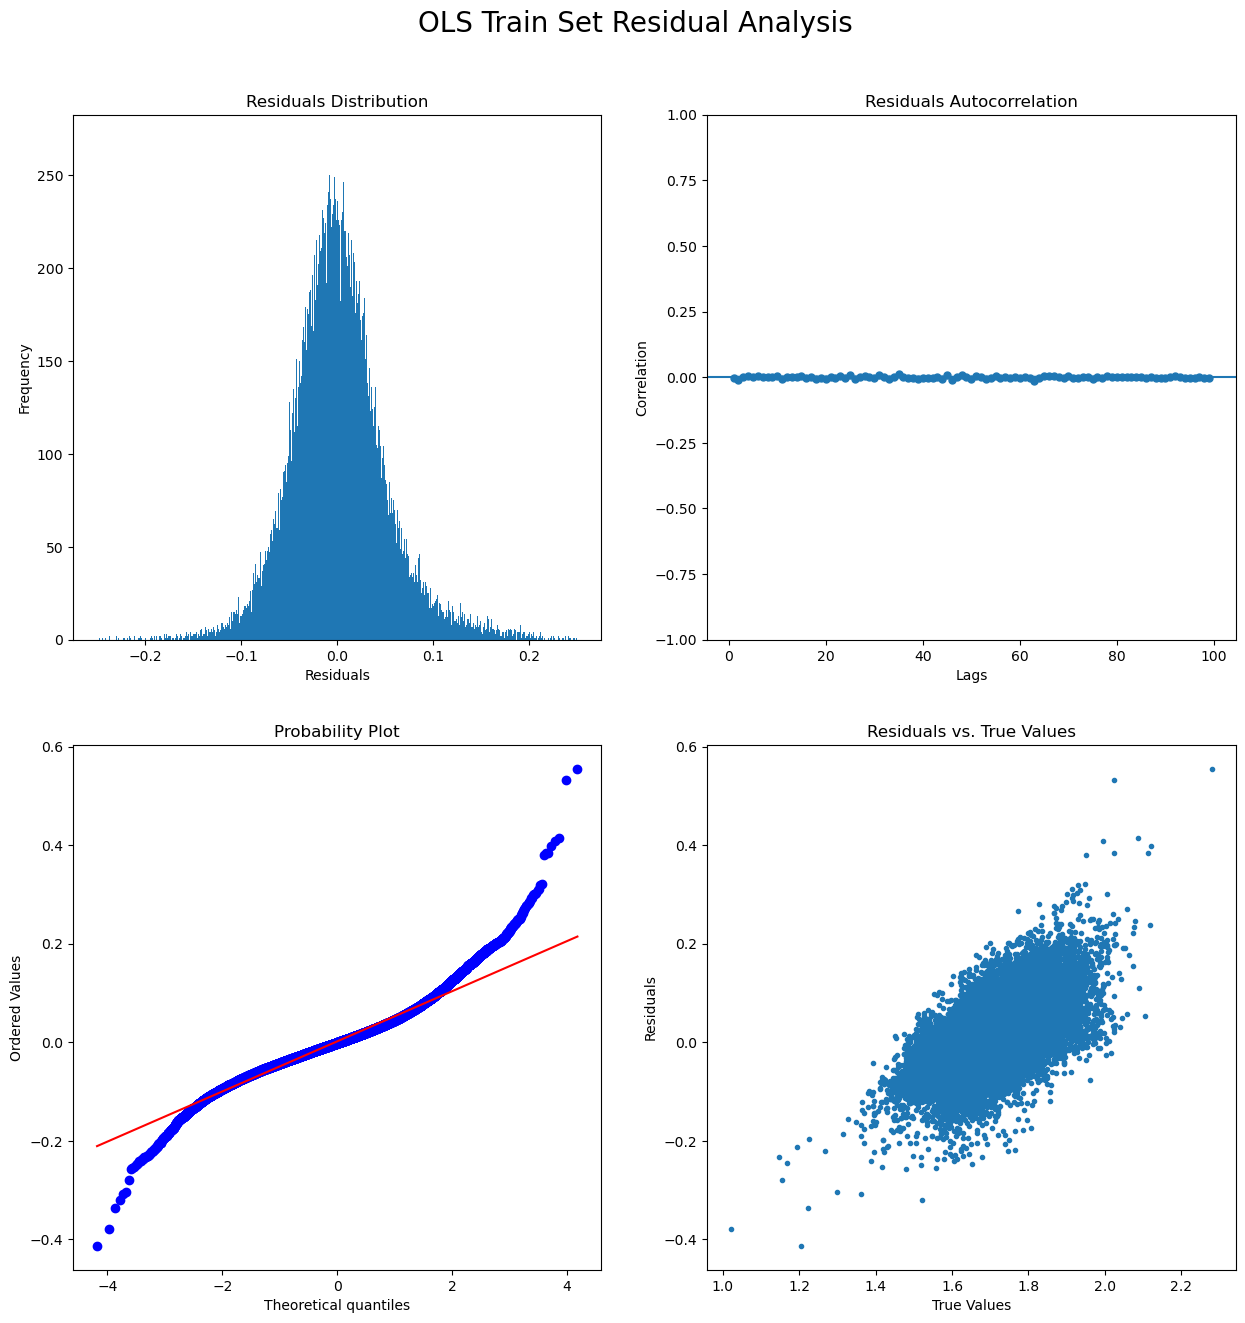

In [322]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [323]:
y_pred = np.exp(reg_model.predict(test))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0027412435629332733
RMSE Test Set =  0.05235688649006235
MAPE Test Set =  0.02254074012908306


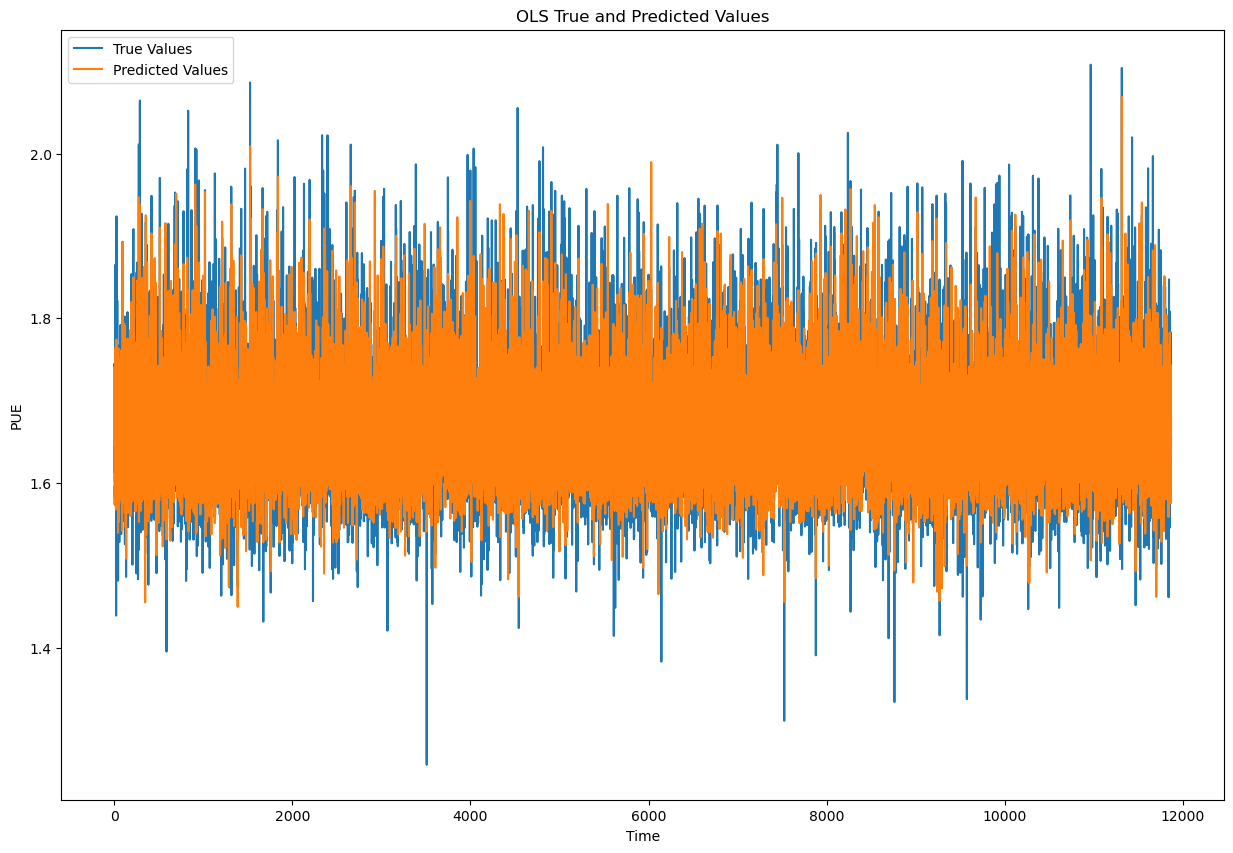

In [324]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

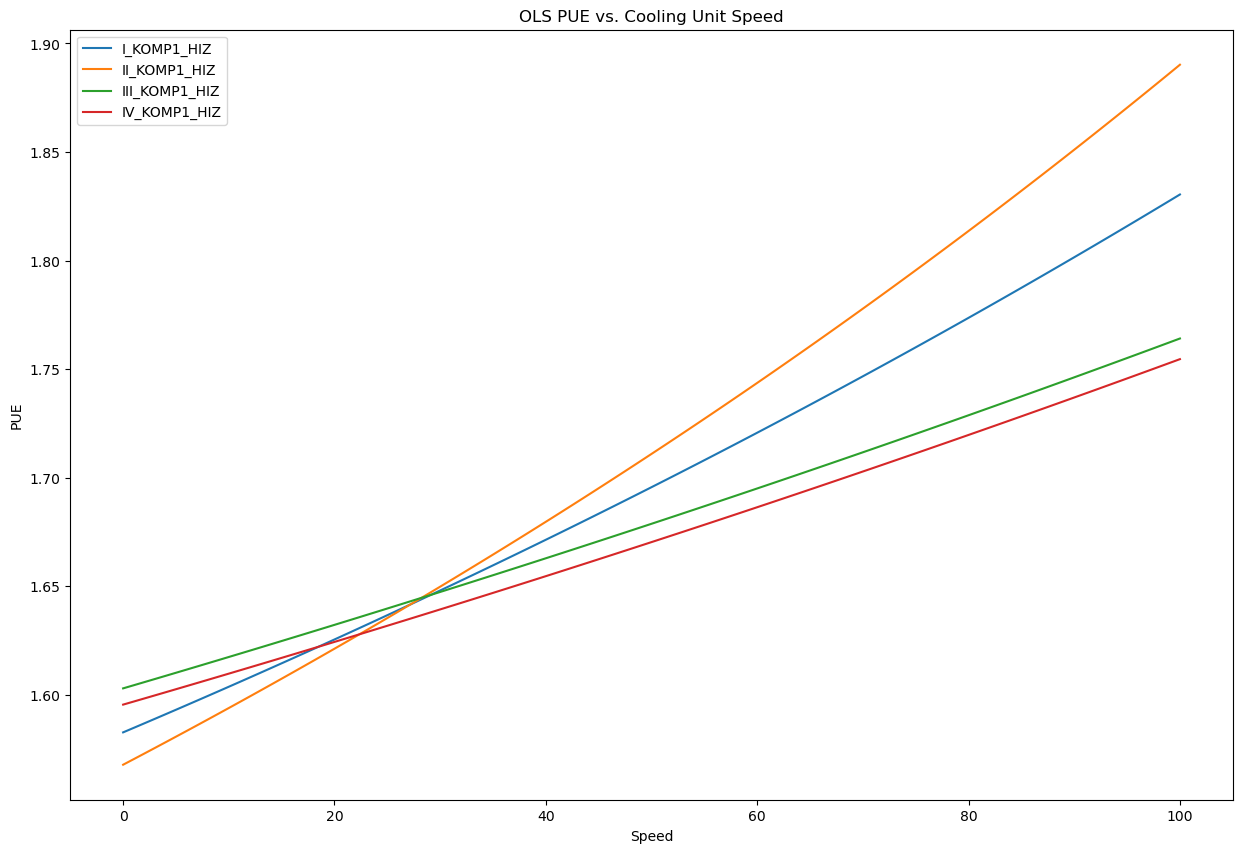

In [325]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[2][i] = y_pred


    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Random Forest

In [326]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [327]:
rf_model = random_forest(max_features='sqrt')

In [328]:
y_pred = np.exp(rf_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.00019816661171161257
RMSE Train Set =  0.014077166323930843
MAPE Train Set =  0.005981862536782521


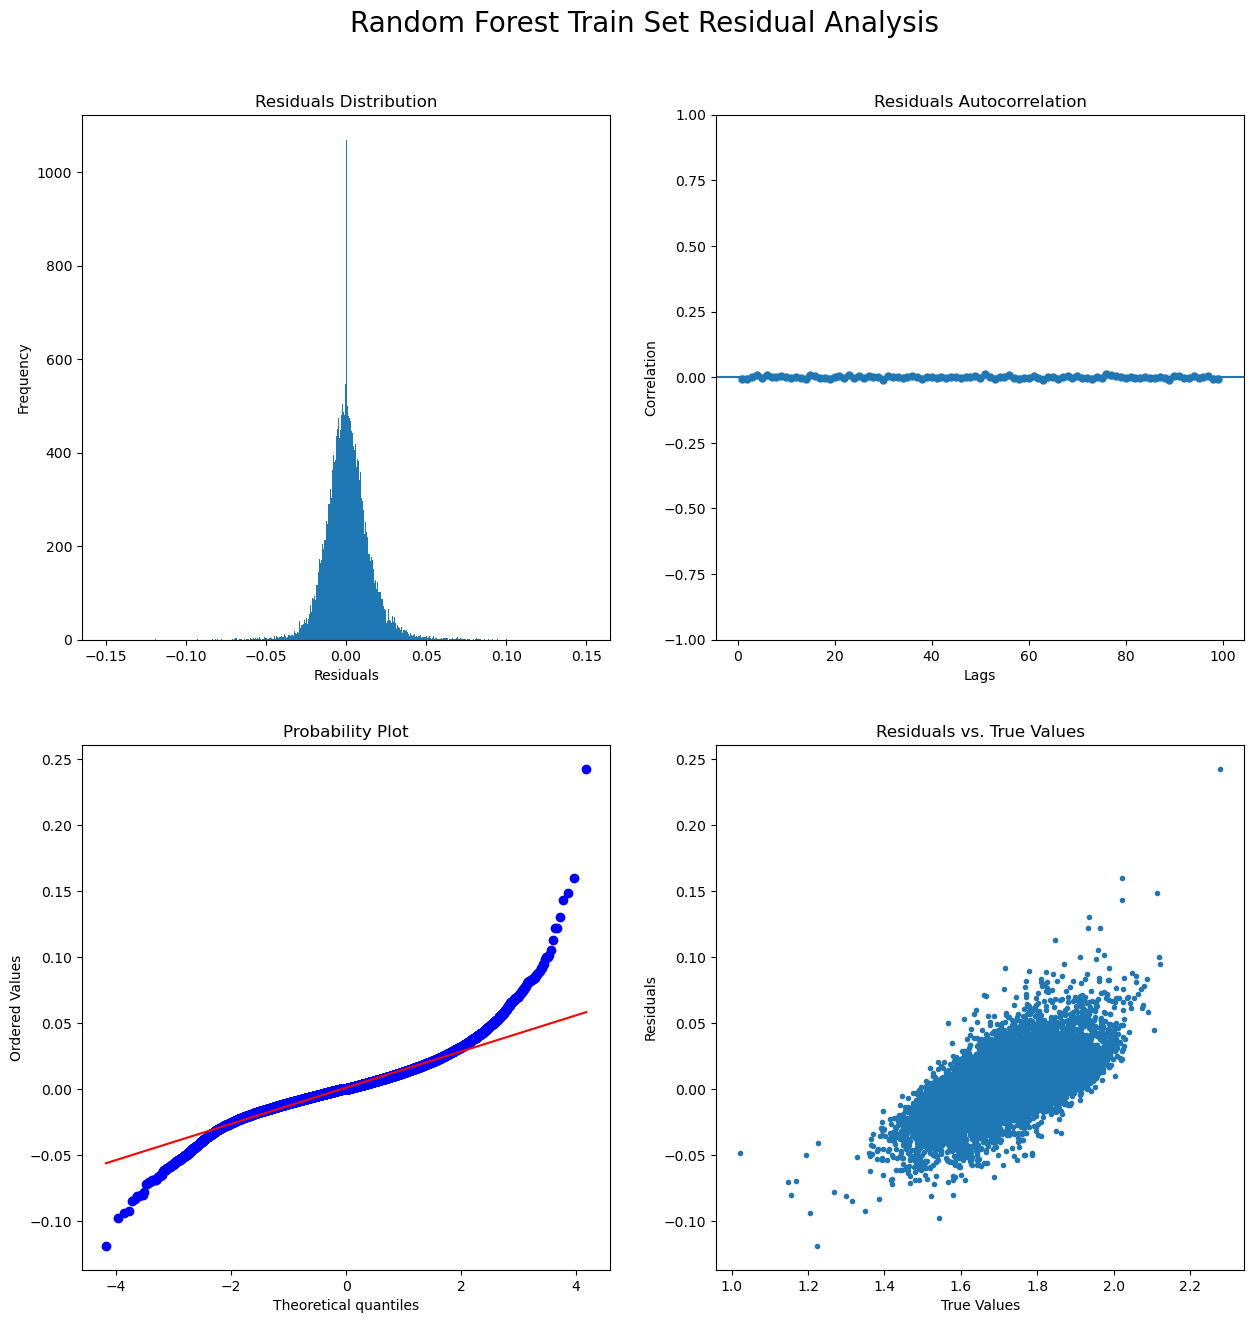

In [329]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.15,0.15))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [330]:
y_pred = np.exp(rf_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0015003294679650267
RMSE Test Set =  0.03873408664167811
MAPE Test Set =  0.01633066832390552


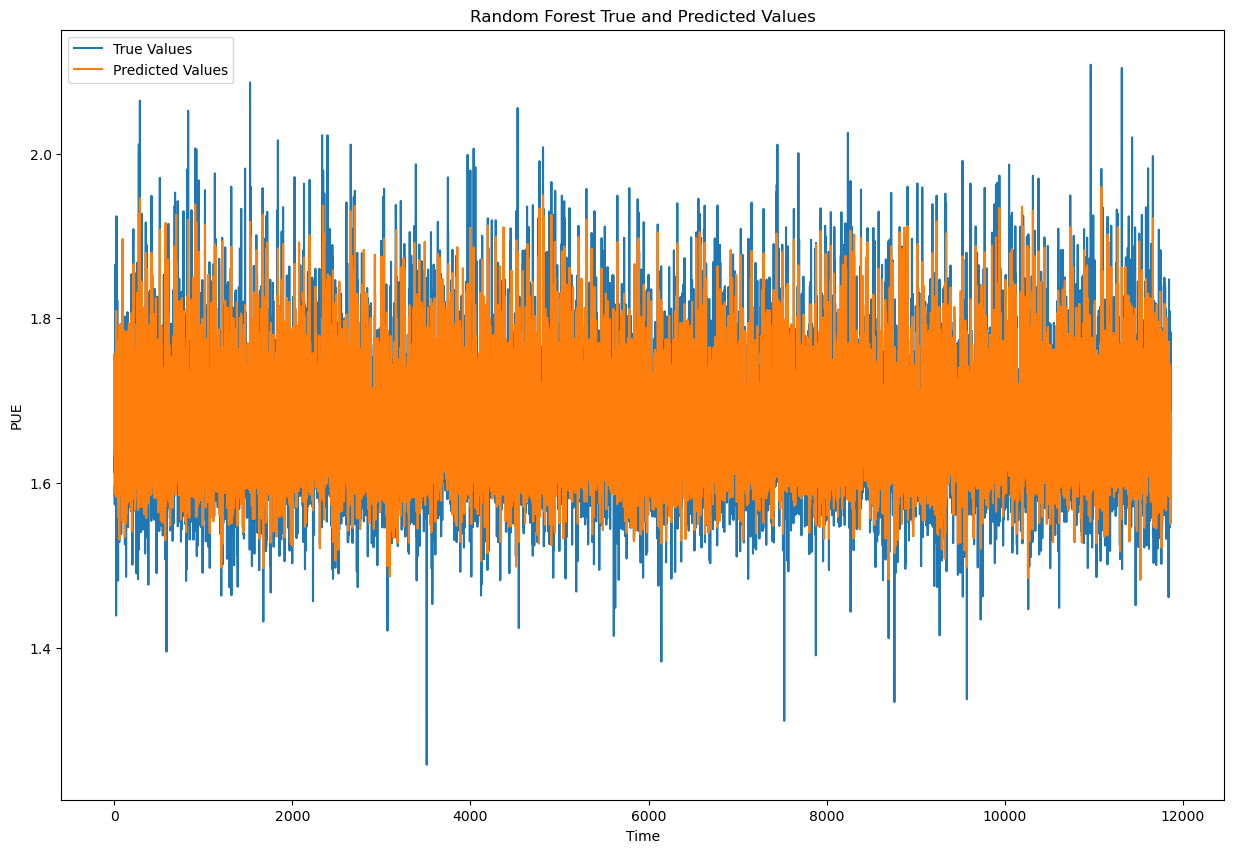

In [331]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

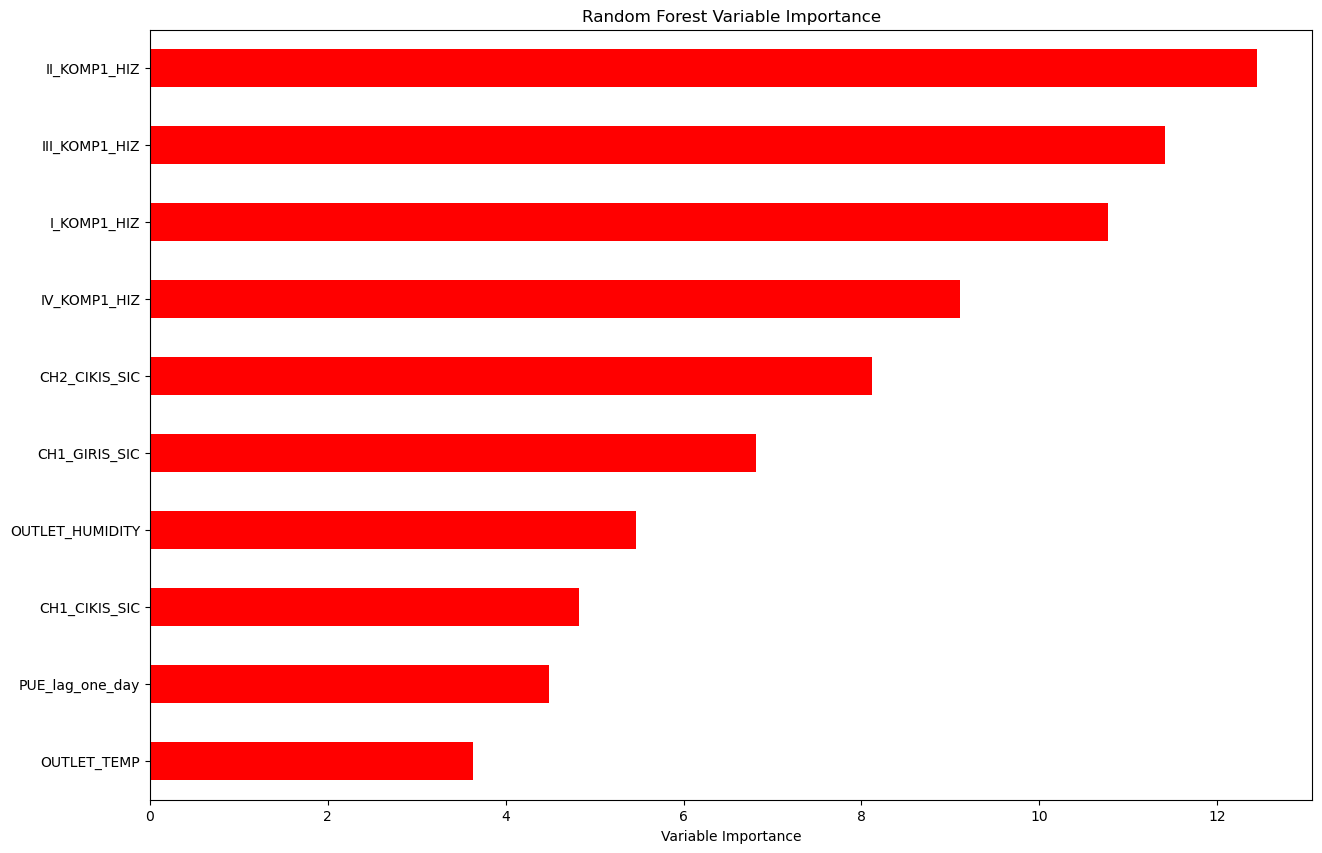

In [332]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

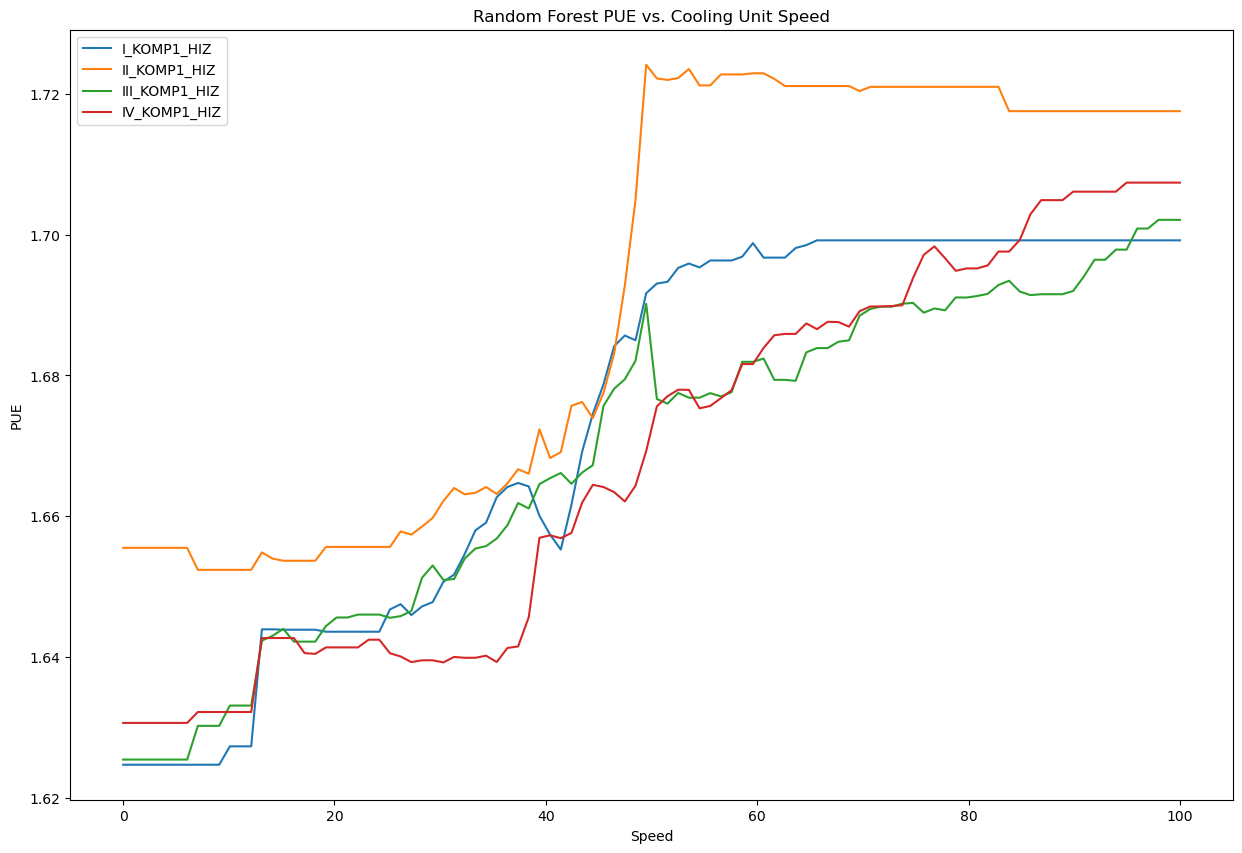

In [333]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Gradient Boosting

In [334]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [335]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [336]:
y_pred = np.exp(gb_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0010690821305111495
RMSE Train Set =  0.03269682141296229
MAPE Train Set =  0.014292606004904167


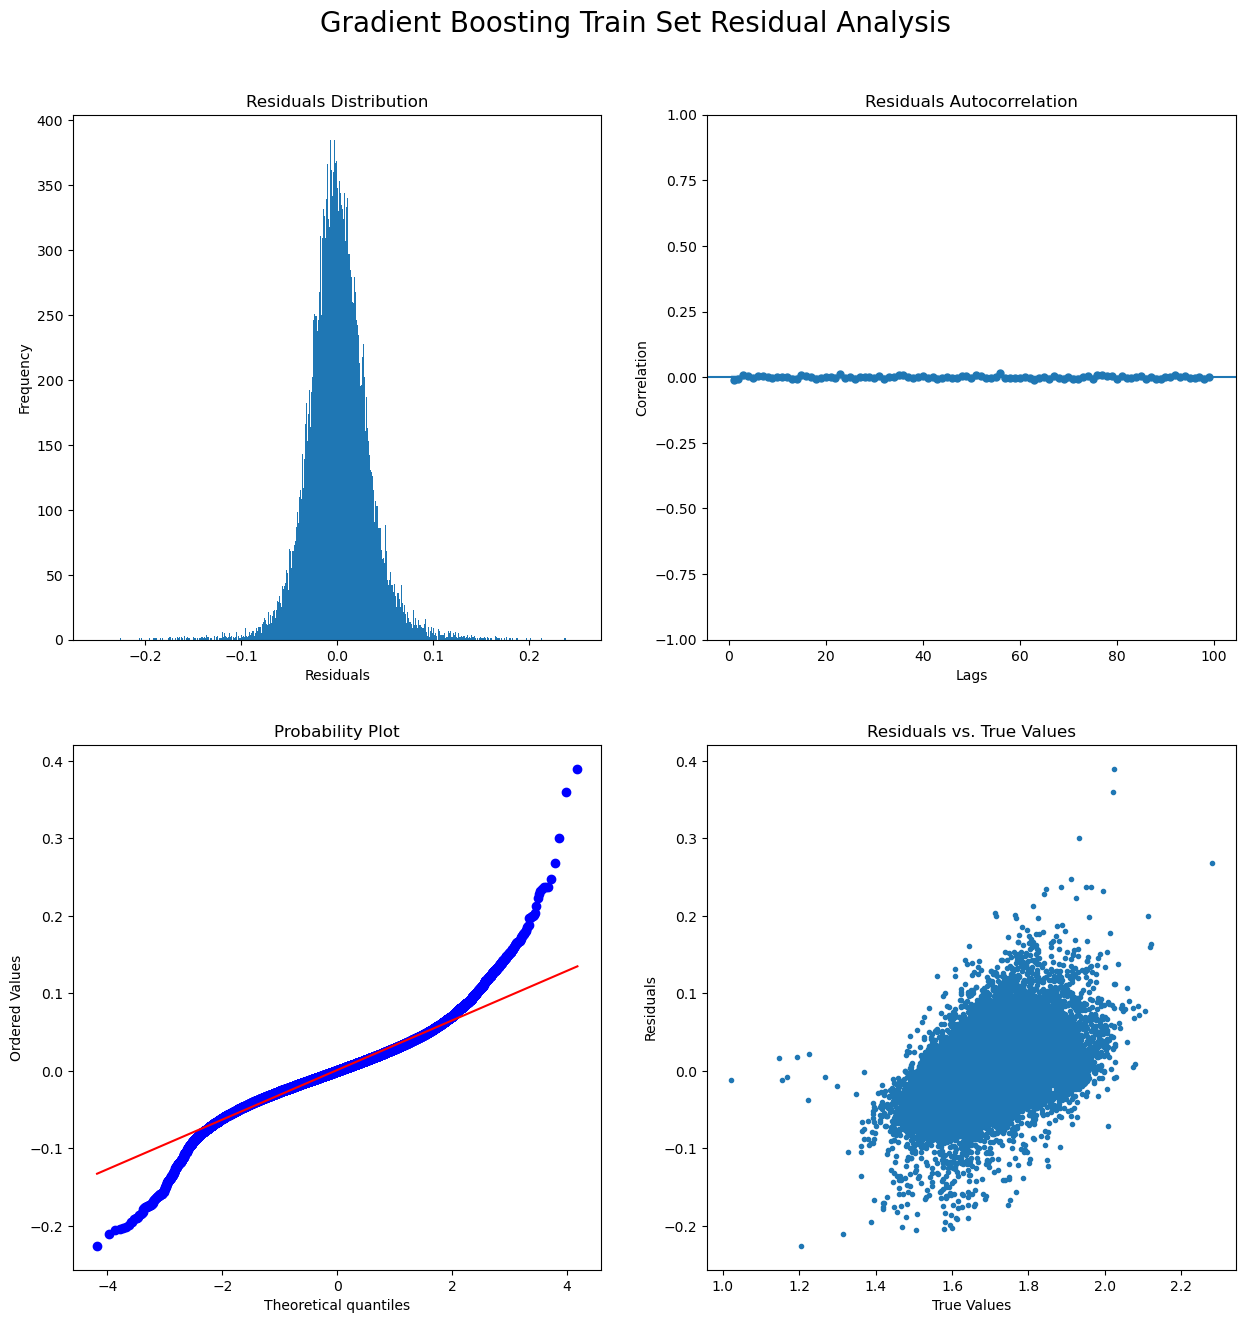

In [337]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [338]:
y_pred = np.exp(gb_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0013058957899426825
RMSE Test Set =  0.036137180160365066
MAPE Test Set =  0.015142557673825517


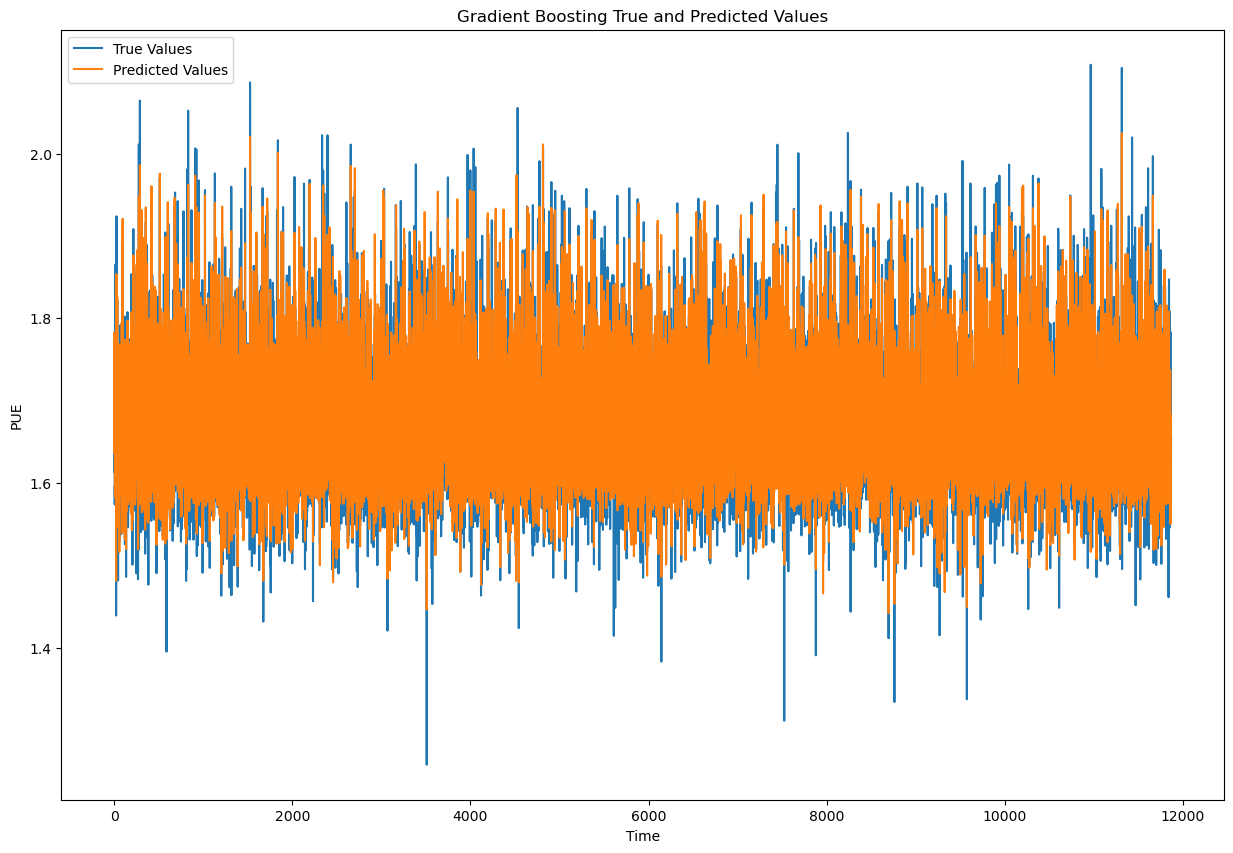

In [339]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

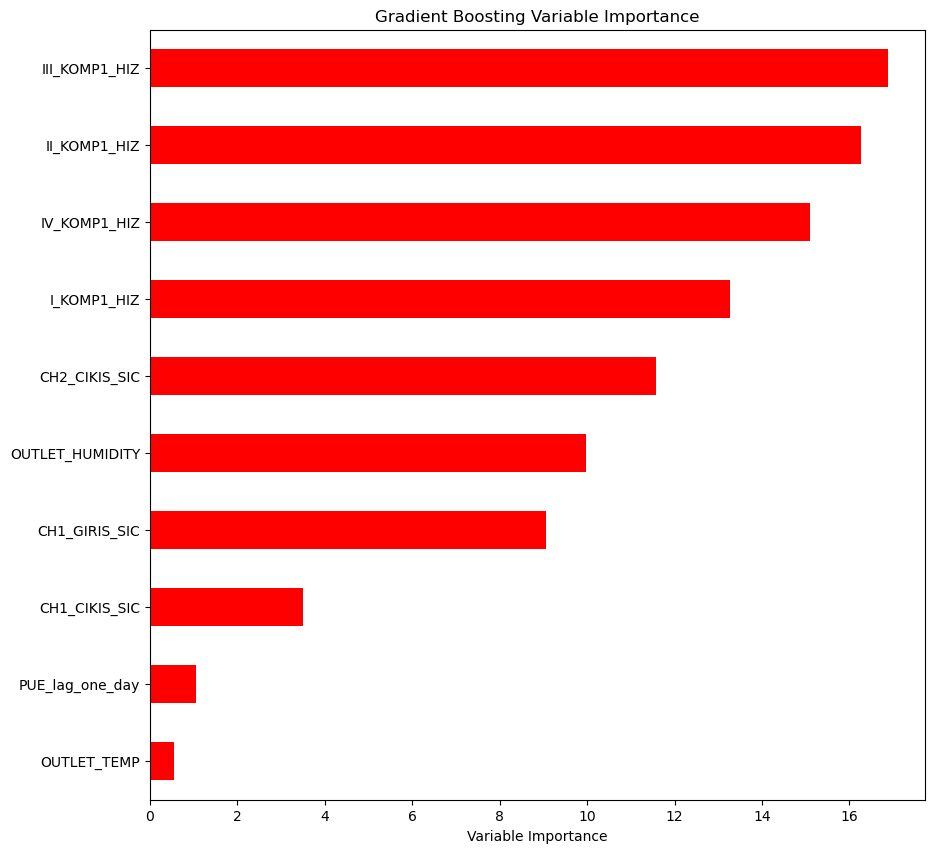

In [340]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

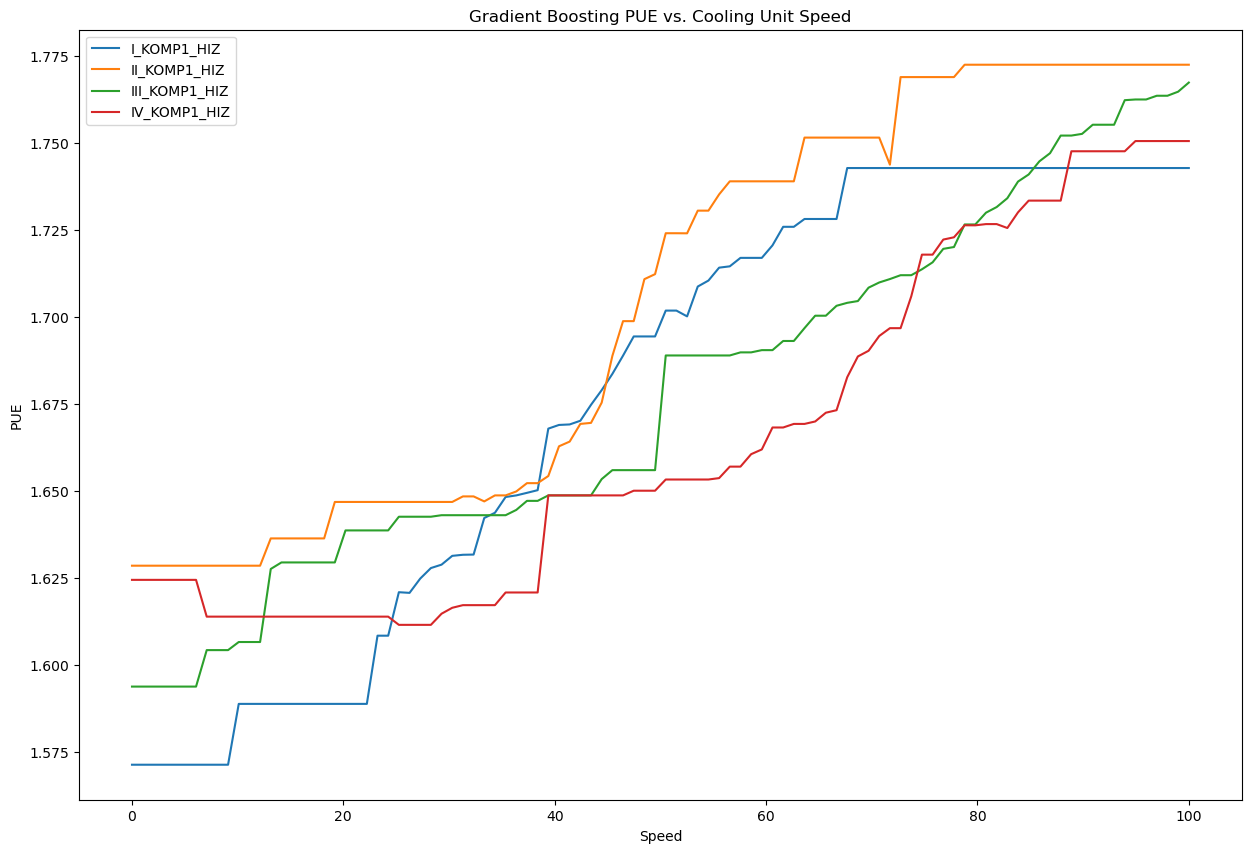

In [341]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Gradient Boosting PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Lasso

In [342]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))  
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [343]:
lasso_model, predictors = lasso(alpha=0.00002)

In [344]:
print(train.iloc[:,list(predictors+2)].columns)

Index(['I_KOMP1_HIZ', 'II_KOMP1_HIZ', 'III_KOMP1_HIZ', 'IV_KOMP1_HIZ',
       'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC', 'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC',
       'SENSOR_I_TEMP', 'OUTLET_HUMIDITY', 'month_4', 'month_5', 'month_7',
       'month_8', 'month_10', 'PUE_lag_one_day'],
      dtype='object')


In [345]:
y_pred = np.exp(lasso_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.00320598284969451
RMSE Test Set =  0.056621399220564216
MAPE Test Set =  0.024869902080428403


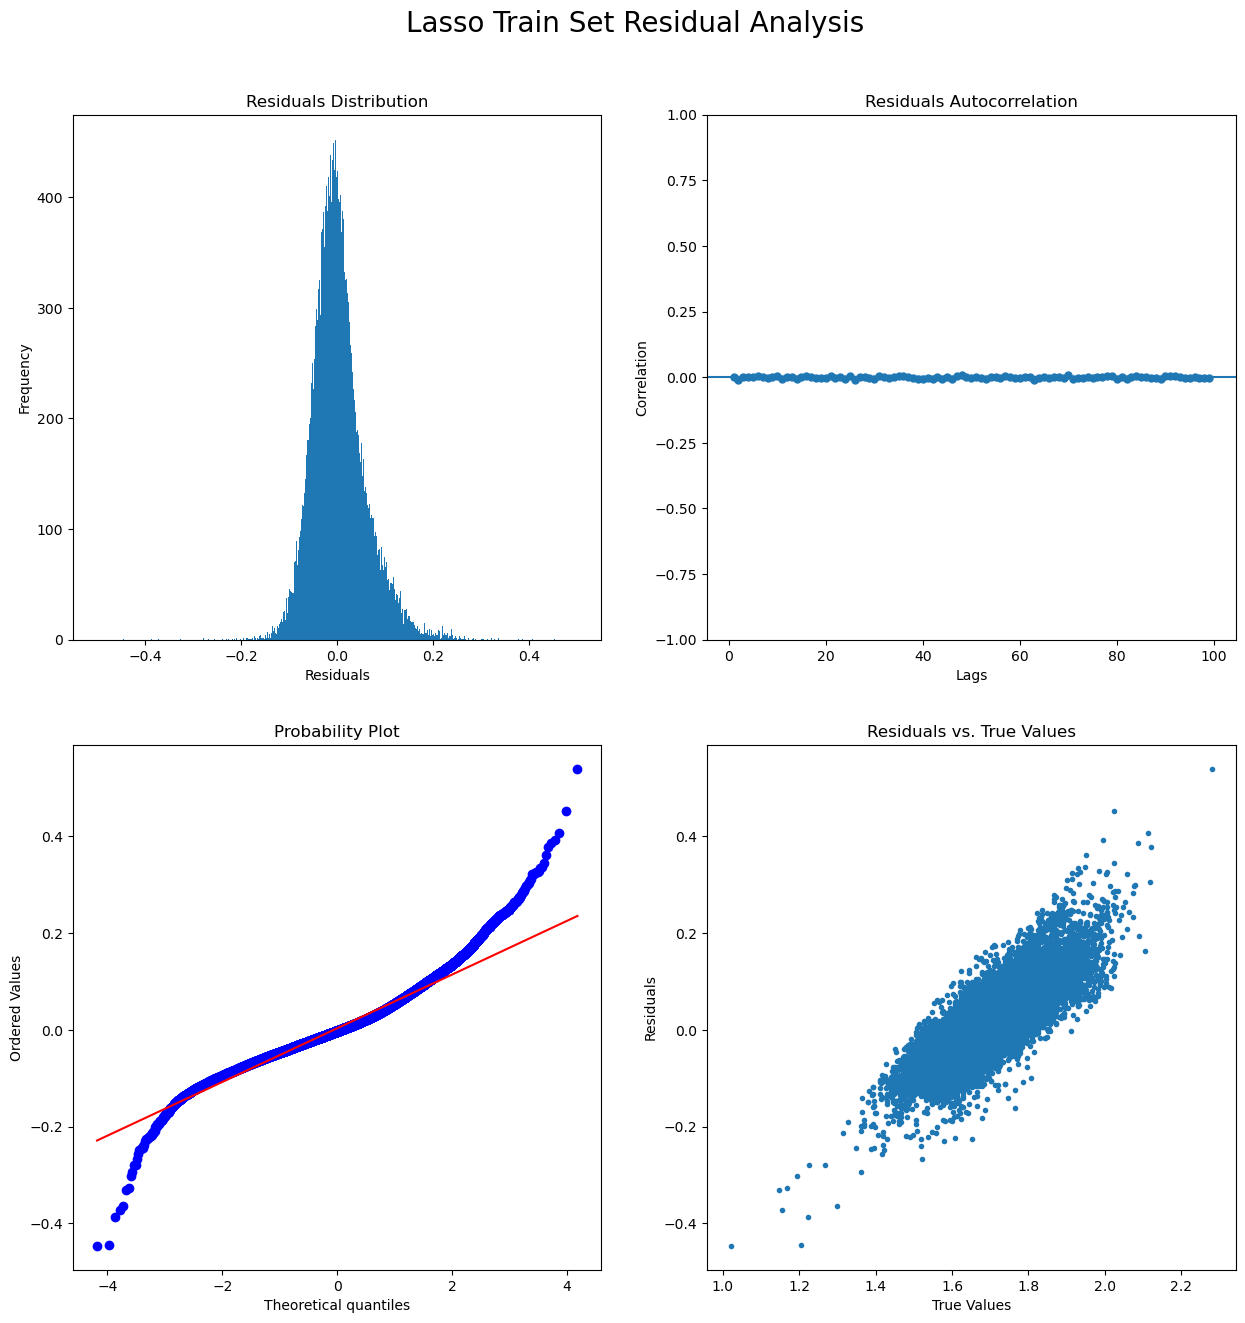

In [346]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [347]:
y_pred = np.exp(lasso_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.003264835866679297
RMSE Test Set =  0.0571387422567149
MAPE Test Set =  0.02504197850442621


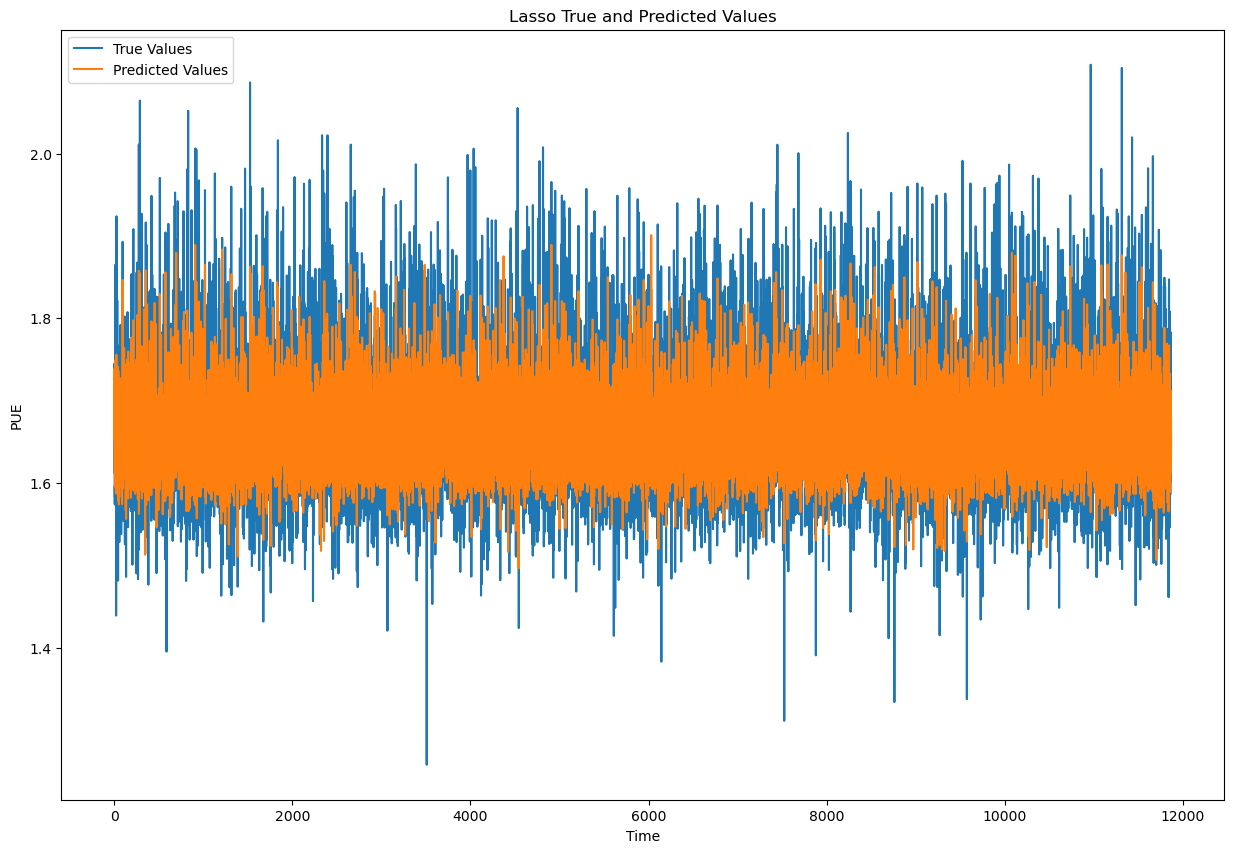

In [348]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

# Sensor-I Temperature Predictions

In [349]:
formula_x1 = "np.log(SENSOR_I_TEMP)"
formula_x2 = "np.log(SENSOR_II_TEMP)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    if FINAL_DF.columns[i] != 'SENSOR_I_TEMP' and FINAL_DF.columns[i] != 'SENSOR_II_TEMP' and FINAL_DF.columns[i] != 'PUE_lag_one_day':
        formula_y += FINAL_DF.columns[i] + " + "

formula_y = formula_y[:-3]

formula1 = formula_x1 + " ~ " + formula_y
formula2 = formula_x2 + " ~ " + formula_y
print(formula1)
print(formula2)

np.log(SENSOR_I_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10
np.log(SENSOR_II_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour

## OLS

In [350]:
reg_model = sm.ols(formula=formula1, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(SENSOR_I_TEMP)   R-squared:                       0.819
Model:                               OLS   Adj. R-squared:                  0.818
Method:                    Least Squares   F-statistic:                     4555.
Date:                   Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                           01:45:43   Log-Likelihood:                 93487.
No. Observations:                  47473   AIC:                        -1.869e+05
Df Residuals:                      47425   BIC:                        -1.865e+05
Df Model:                             47                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8212      0.010    186.274      0.000       1.802       1.840
I_KOMP1_HIZ         0.0001   1.66e-05      7.049      0.000    8.43e-05       0.000
II_KOMP1_HIZ    -3.199e-06   1.52e-05     -0.211      0.833    -3.3e-05    2.66e-05
III_KOMP1_HIZ   -4.653e-05   9.85e-06     -4.721      0.000   -6.58e-05   -2.72e-05
IV_KOMP1_HIZ        0.0001   1.28e-05     11.601      0.000       0.000       0.000
CH1_CIKIS_SIC      -0.0008      0.000     -3.580      0.000      -0.001      -0.000
CH1_GIRIS_SIC       0.0050      0.000     22.589      0.000       0.005       0.005
CH2_CIKIS_SIC      -0.0015   6.84e-05    -22.399      0.000      -0.002      -0.001
CH2_GIRIS_SIC   -9.875e-05   1.64e-05     -6.003      0.000      -0.000   -6.65e-05
CH3_CIKIS_SIC      -0.0424      0.000   -193.047      0.000      -0.043      -0.042
CH3_GIRIS_SIC       0.0458      0.001     86.093      0.000       0.045       0.047
OUTLET_TEMP        -0.0339      0.000   -117.410      0.000      -0.034      -0.033
OUTLET_HUMIDITY     0.0812      0.001    127.704      0.000       0.080       0.082
Mon                 0.0014      0.000      3.366      0.001       0.001       0.002
Tue                -0.0007      0.000     -1.670      0.095      -0.002       0.000
Wed             -9.472e-05      0.000     -0.219      0.827      -0.001       0.001
Thu                -0.0002      0.000     -0.556      0.578      -0.001       0.001
Fri                -0.0018      0.000     -4.069      0.000      -0.003      -0.001
Sat                -0.0026      0.000     -6.021      0.000      -0.003      -0.002
hour_0              0.0016      0.001      1.885      0.060   -6.24e-05       0.003
hour_1              0.0029      0.001      3.519      0.000       0.001       0.005
hour_2              0.0027      0.001      3.201      0.001       0.001       0.004
hour_3              0.0026      0.001      3.080      0.002       0.001       0.004
hour_4              0.0025      0.001      3.031      0.002       0.001       0.004
hour_5              0.0047      0.001      5.740      0.000       0.003       0.006
hour_6              0.0052      0.001      6.378      0.000       0.004       0.007
hour_7              0.0055      0.001      6.849      0.000       0.004       0.007
hour_8              0.0058      0.001      7.016      0.000       0.004       0.007
hour_9              0.0031      0.001      3.752      0.000       0.001       0.005
hour_10             0.0013      0.001      1.586      0.113      -0.000       0.003
hour_11            -0.0034      0.001     -4.035      0.000      -0.005      -0.002
hour_12            -0.0051      0.001     -5.997      0.000      -0.007      -0.003
hour_13            -0.0039      0.001     -4.614      0.000      -0.006      -0.002
hour_14            -0.0039

In [351]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.3587652939225082
RMSE Train Set =  0.5989701945193168
MAPE Train Set =  0.02454358535823065


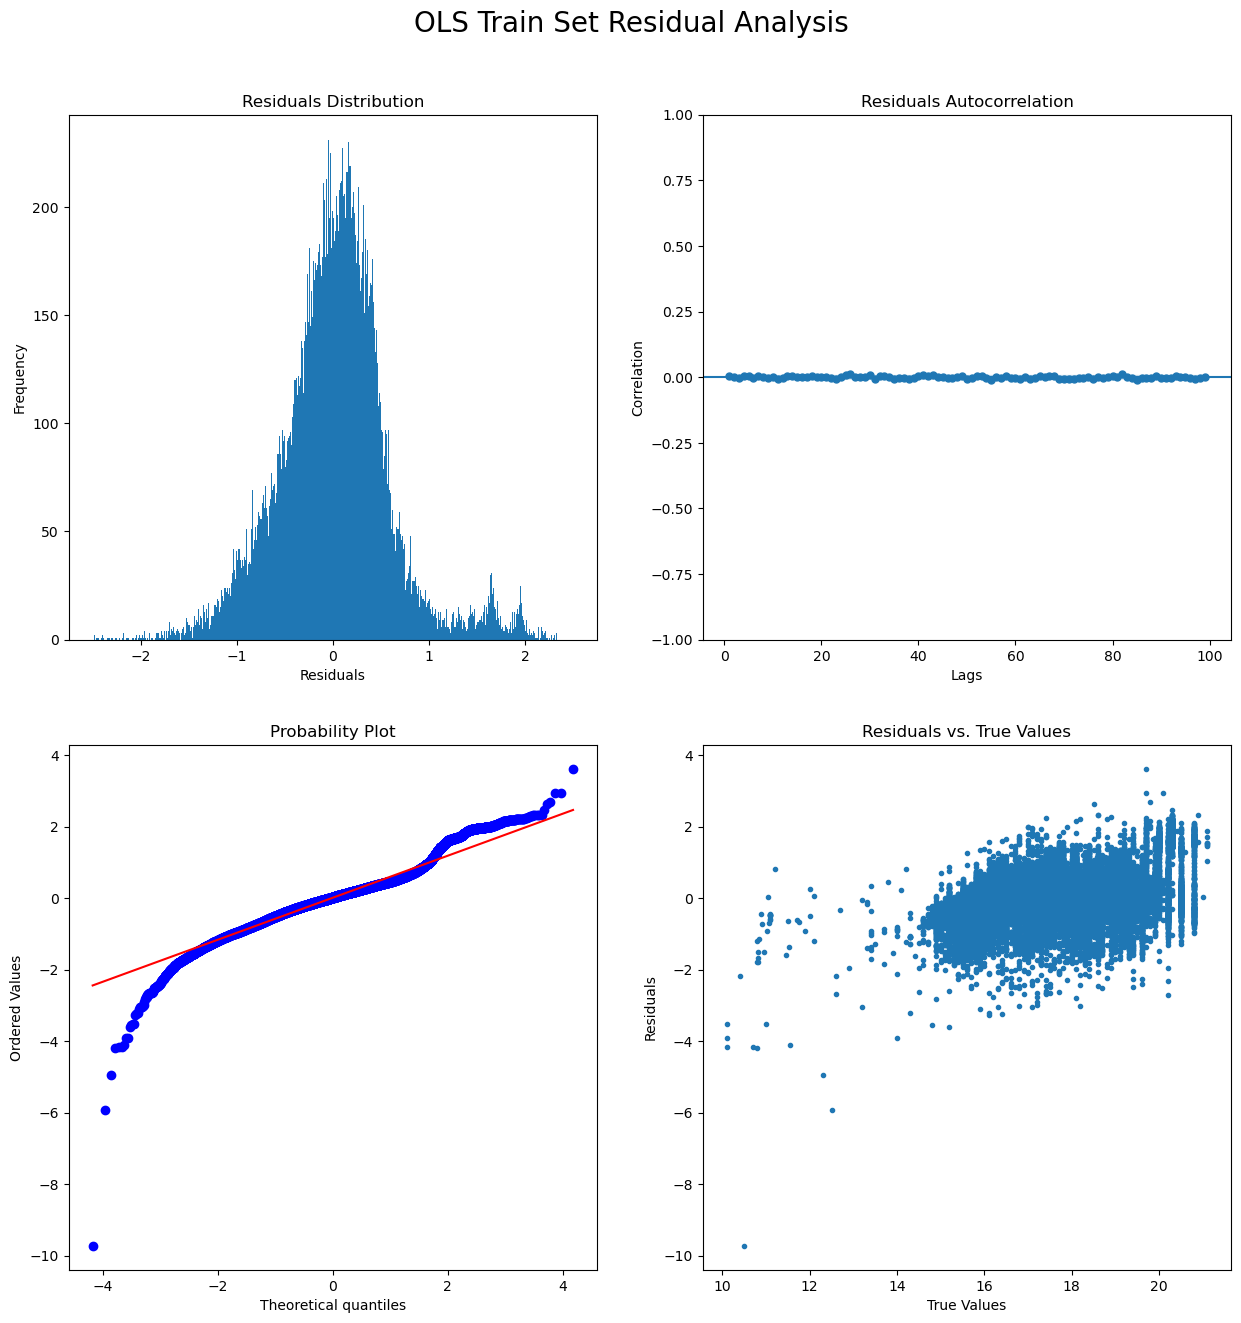

In [352]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [353]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.3578207780622439
RMSE Test Set =  0.5981812251000894
MAPE Test Set =  0.02449867631493234


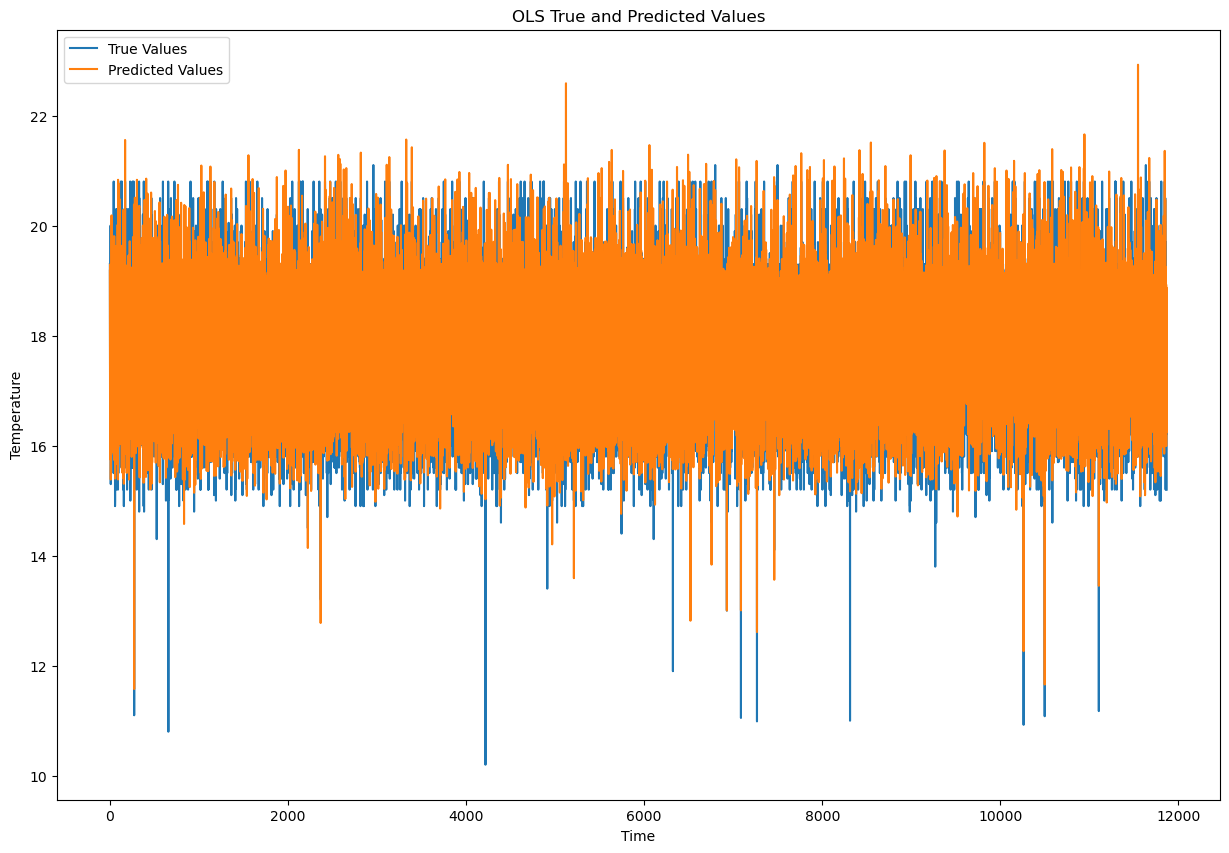

In [354]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

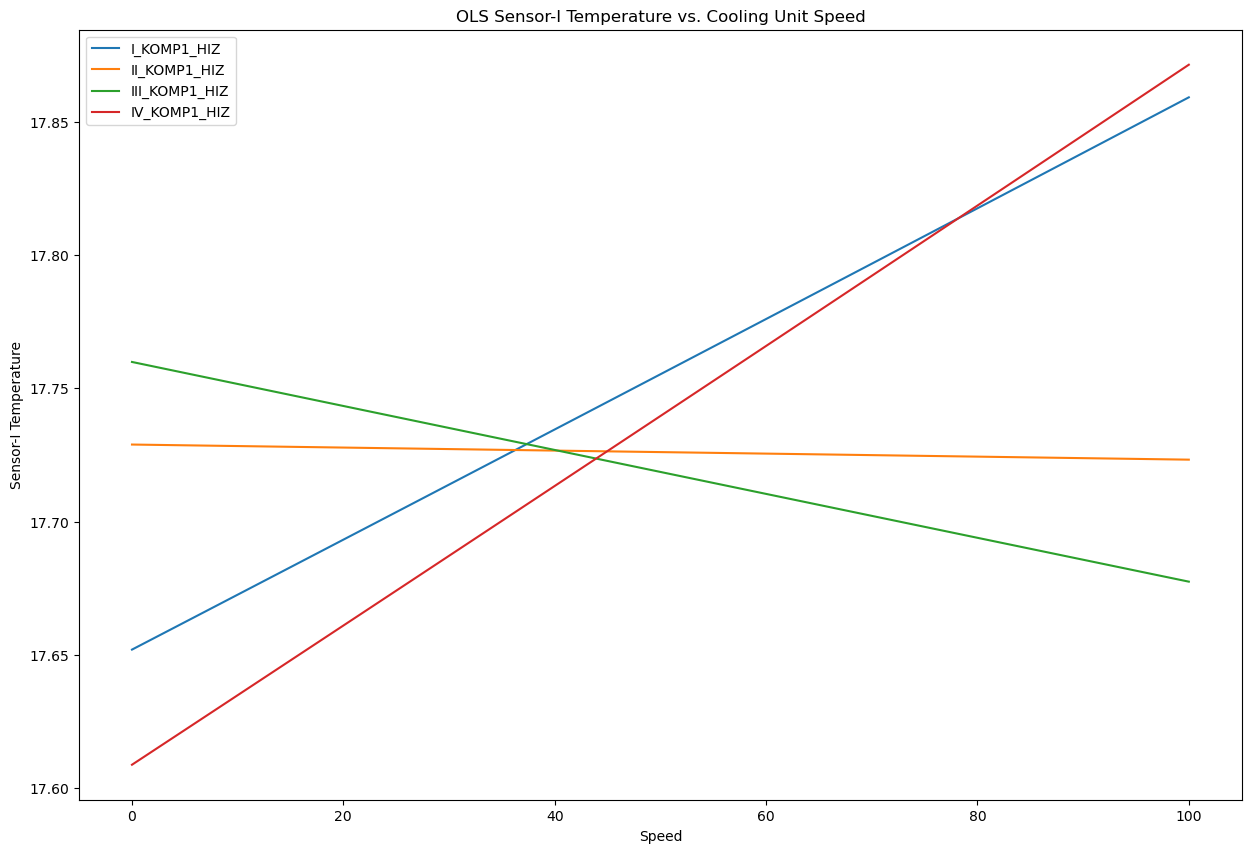

In [355]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('OLS Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Random Forest

In [356]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return result

In [357]:
rf_model = random_forest(max_features='sqrt')

In [358]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.010541527489701047
RMSE Train Set =  0.10267194110223614
MAPE Train Set =  0.0030689243346226857


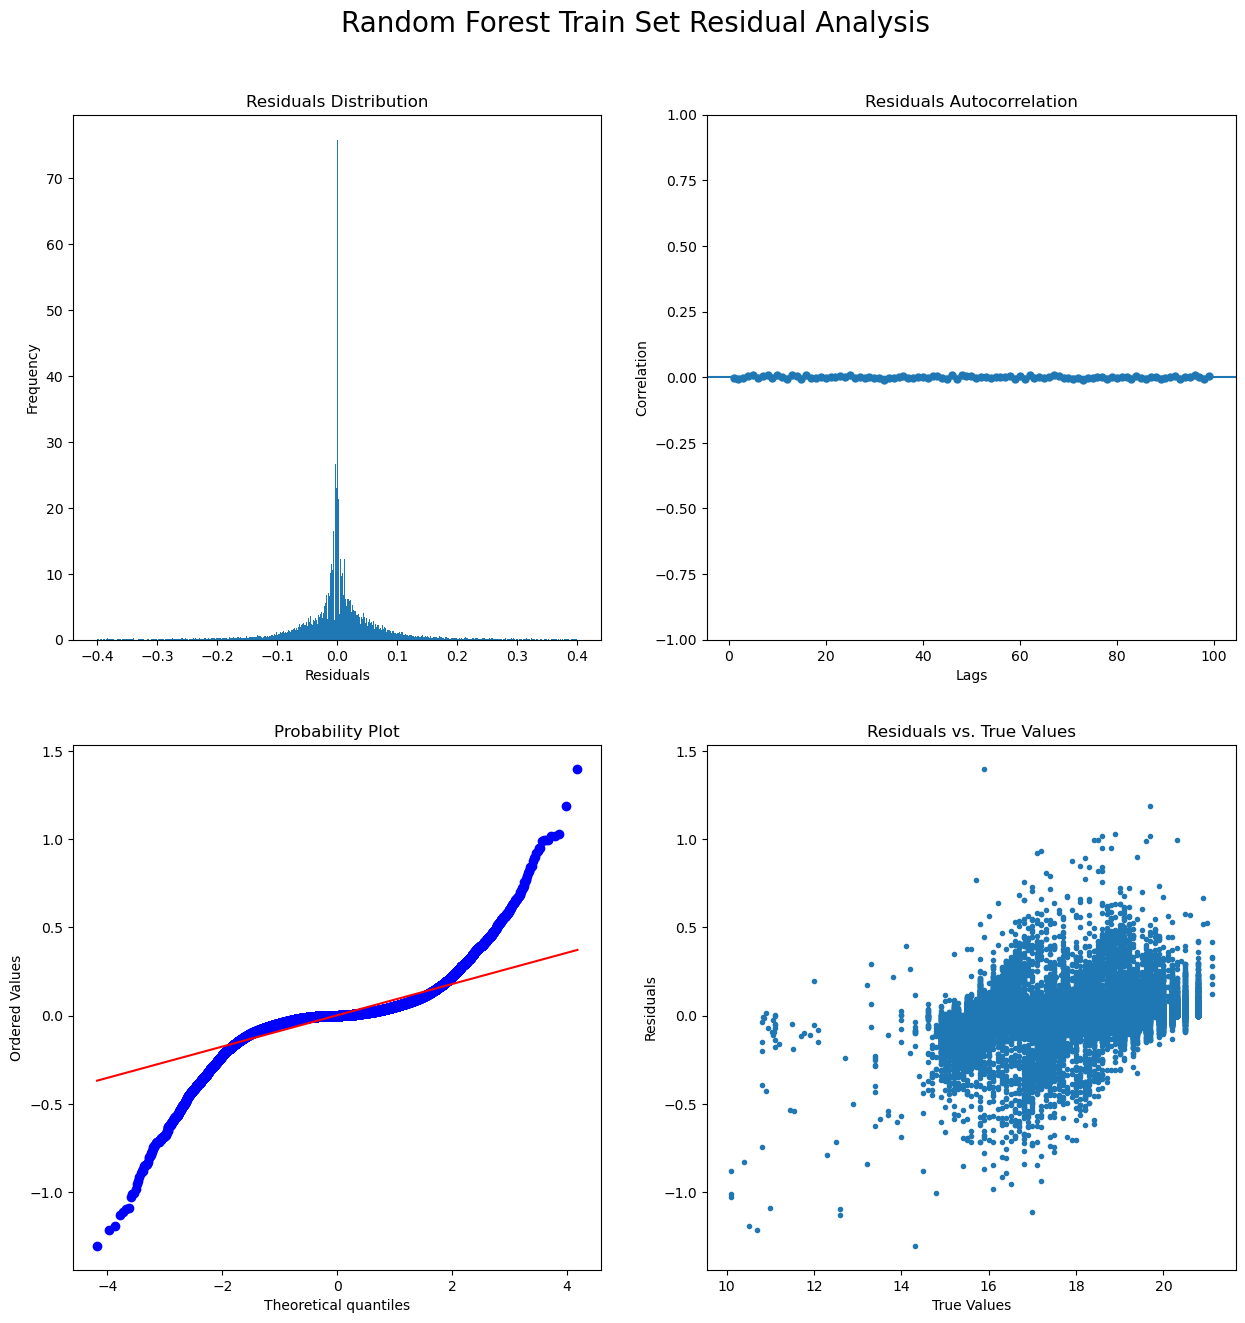

In [359]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.4,0.4), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [360]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.08156071380318791
RMSE Test Set =  0.28558836426435147
MAPE Test Set =  0.00826729390460728


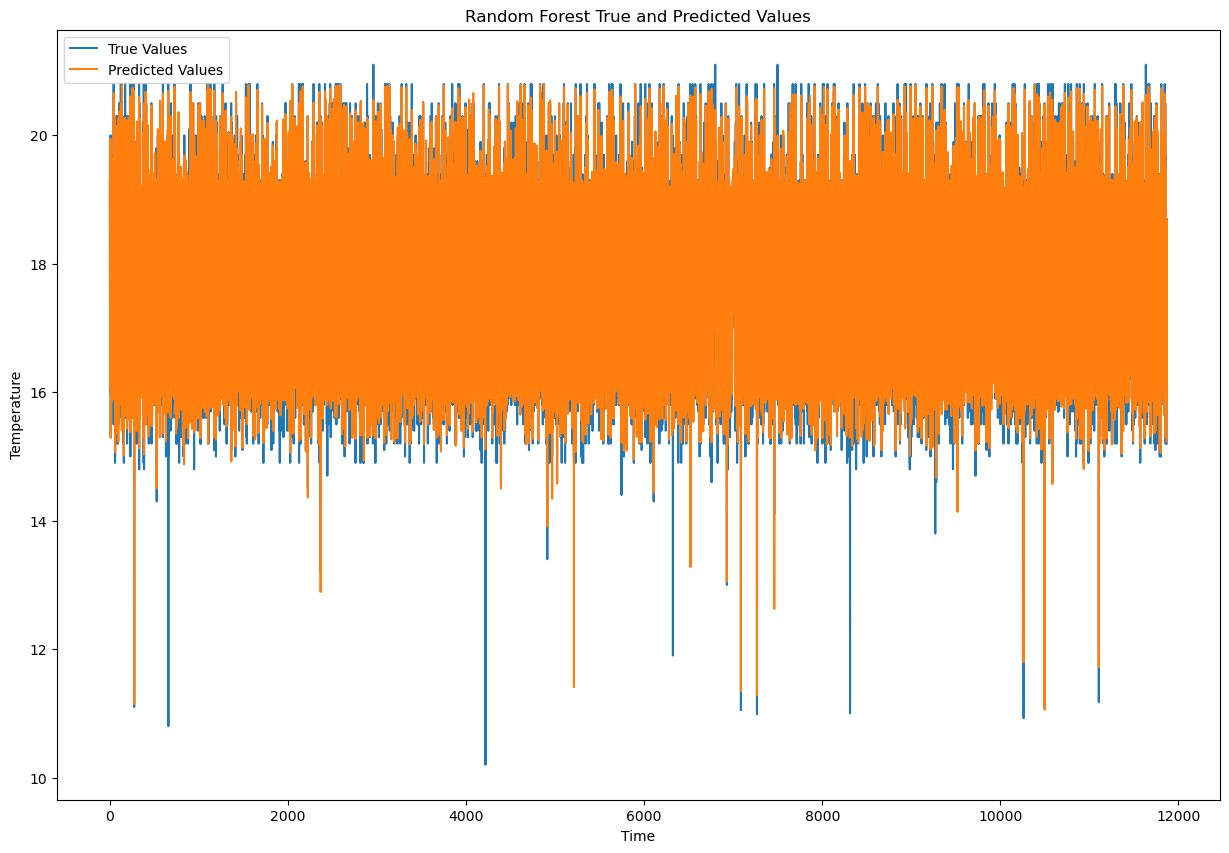

In [361]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

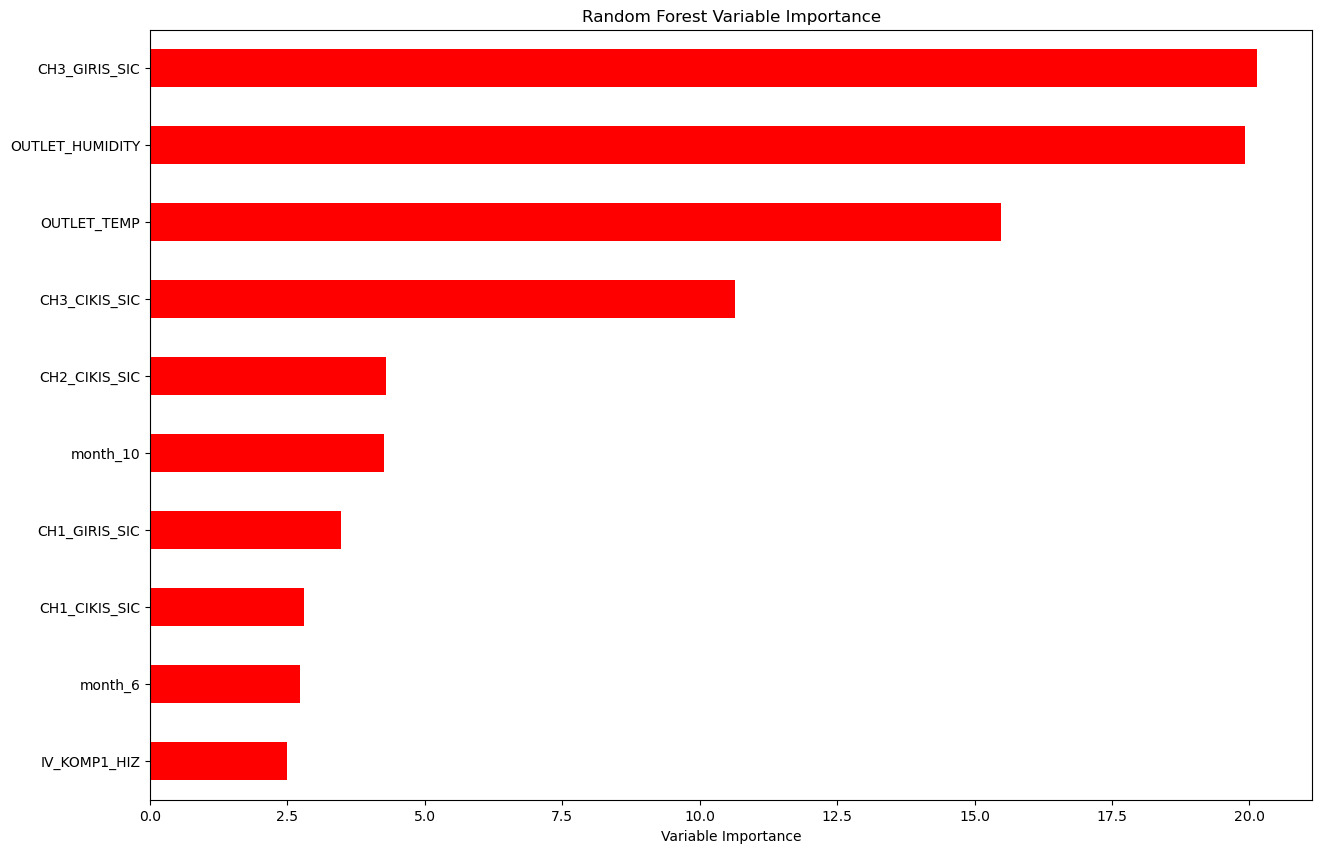

In [362]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

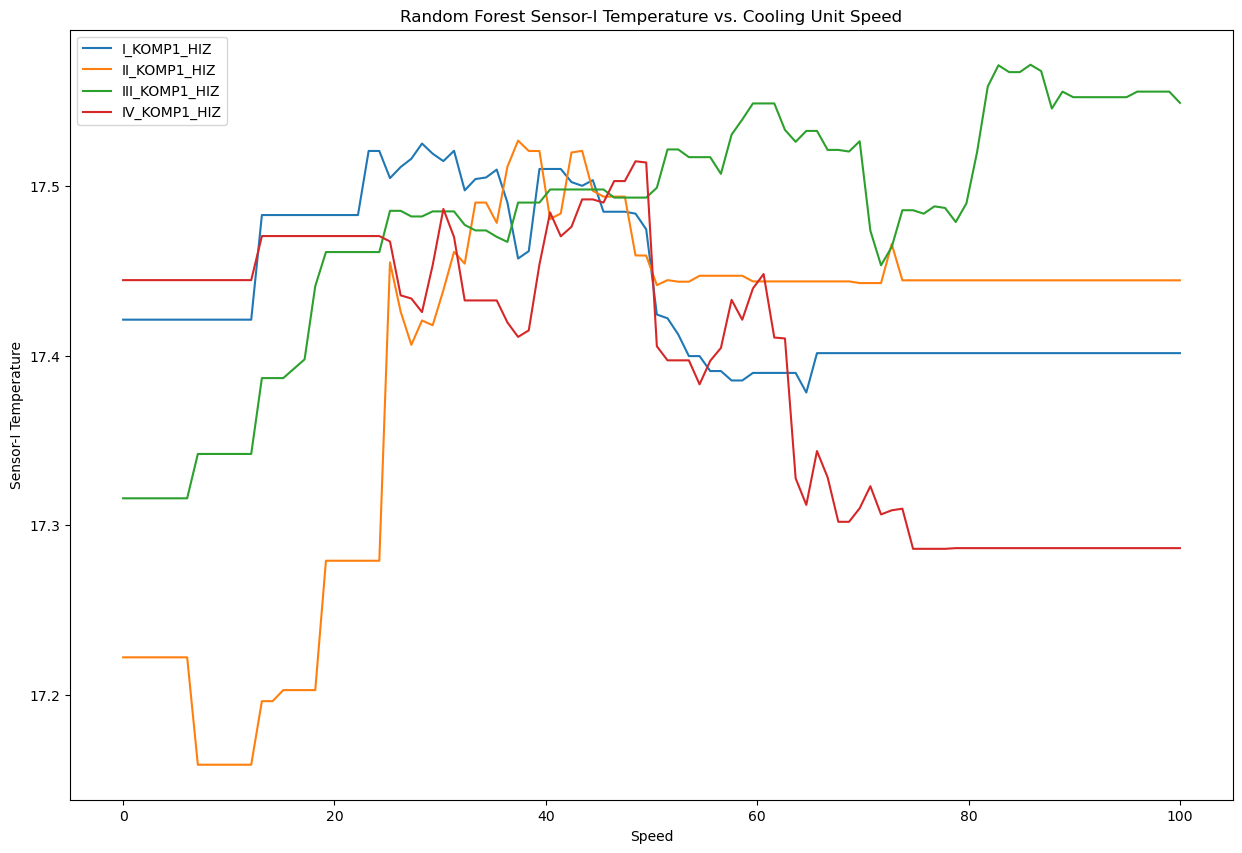

In [363]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [364]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return result

In [365]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [366]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.08898359800053318
RMSE Train Set =  0.29830118672330685
MAPE Train Set =  0.01051711890166292


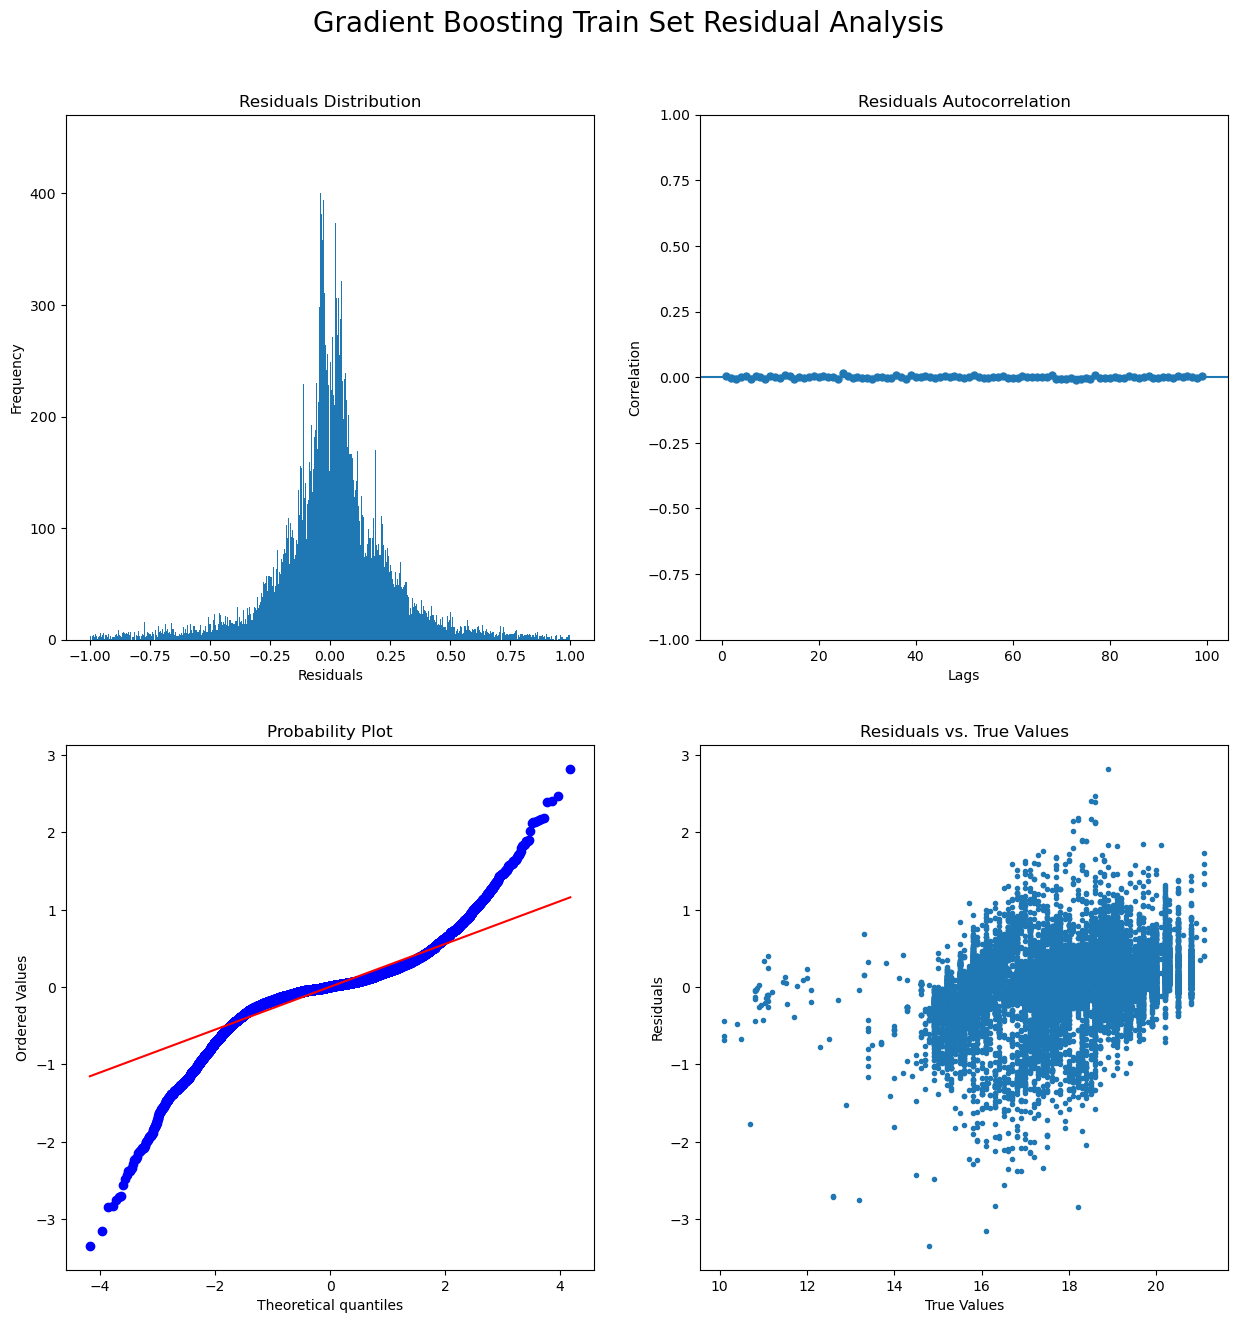

In [367]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-1,1))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [368]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.10860486148618291
RMSE Test Set =  0.3295525170381542
MAPE Test Set =  0.011048881018062262


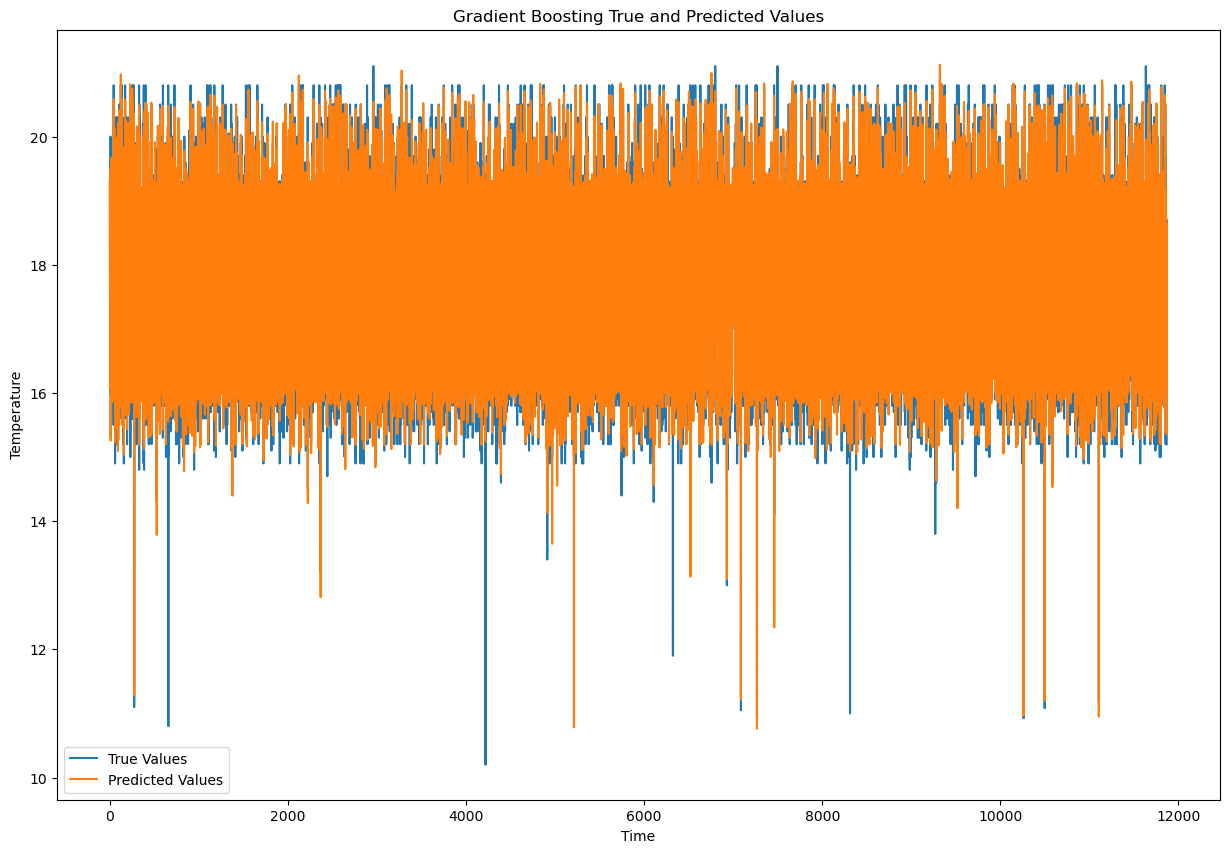

In [369]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

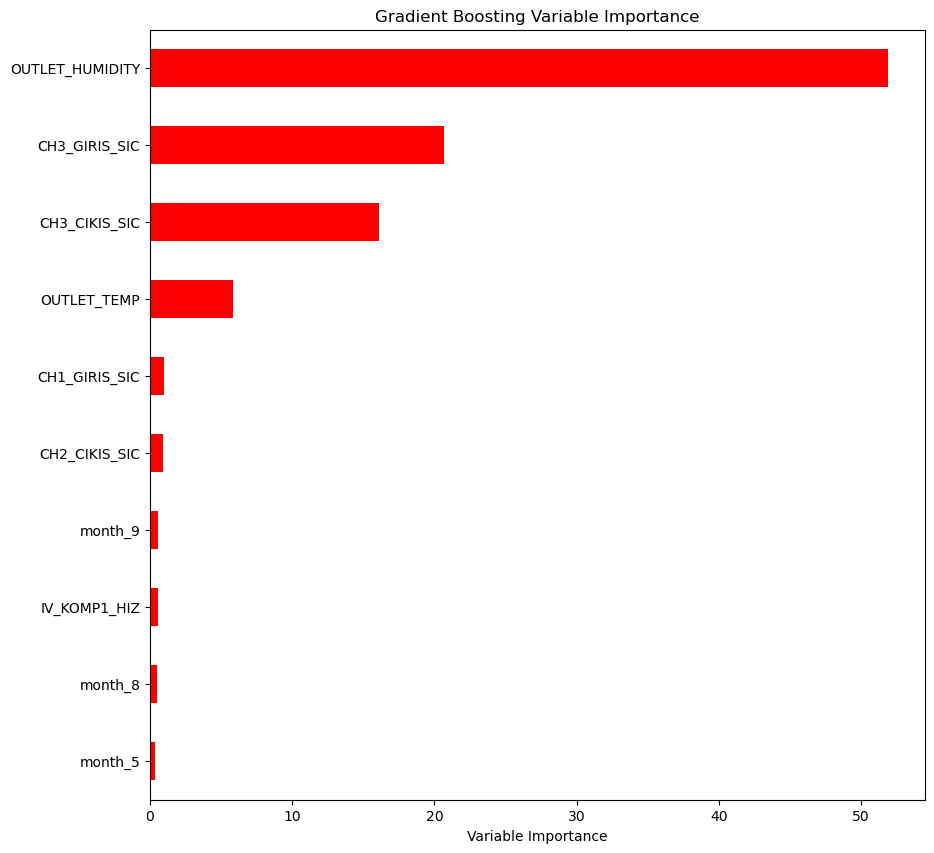

In [370]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

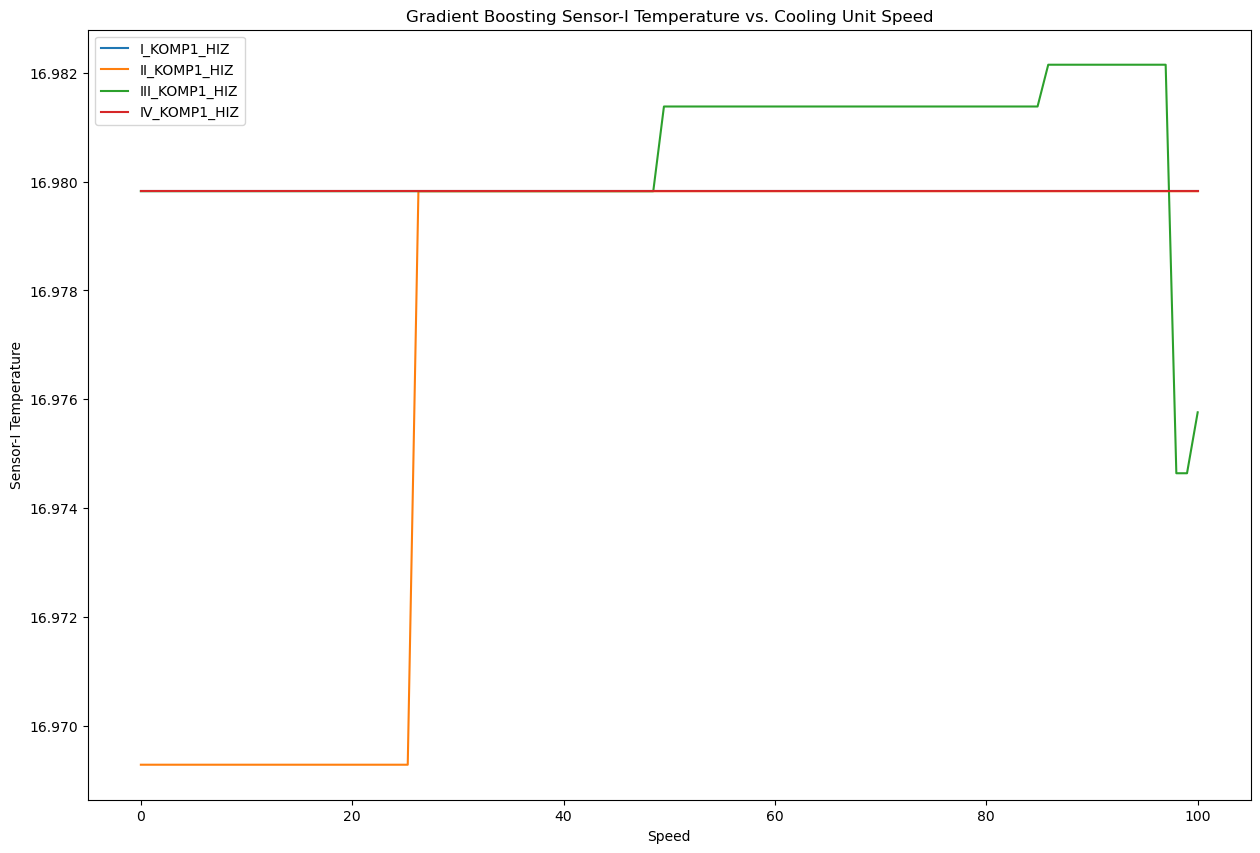

In [371]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Lasso

In [372]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [373]:
lasso_model, predictors = lasso(alpha=0.00002)

In [374]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['CH1_GIRIS_SIC', 'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC', 'OUTLET_HUMIDITY',
       'month_4', 'month_7', 'month_8', 'month_9', 'month_10'],
      dtype='object')


In [375]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.5116498993915559
RMSE Test Set =  0.7152970707276495
MAPE Test Set =  0.031270918938658285


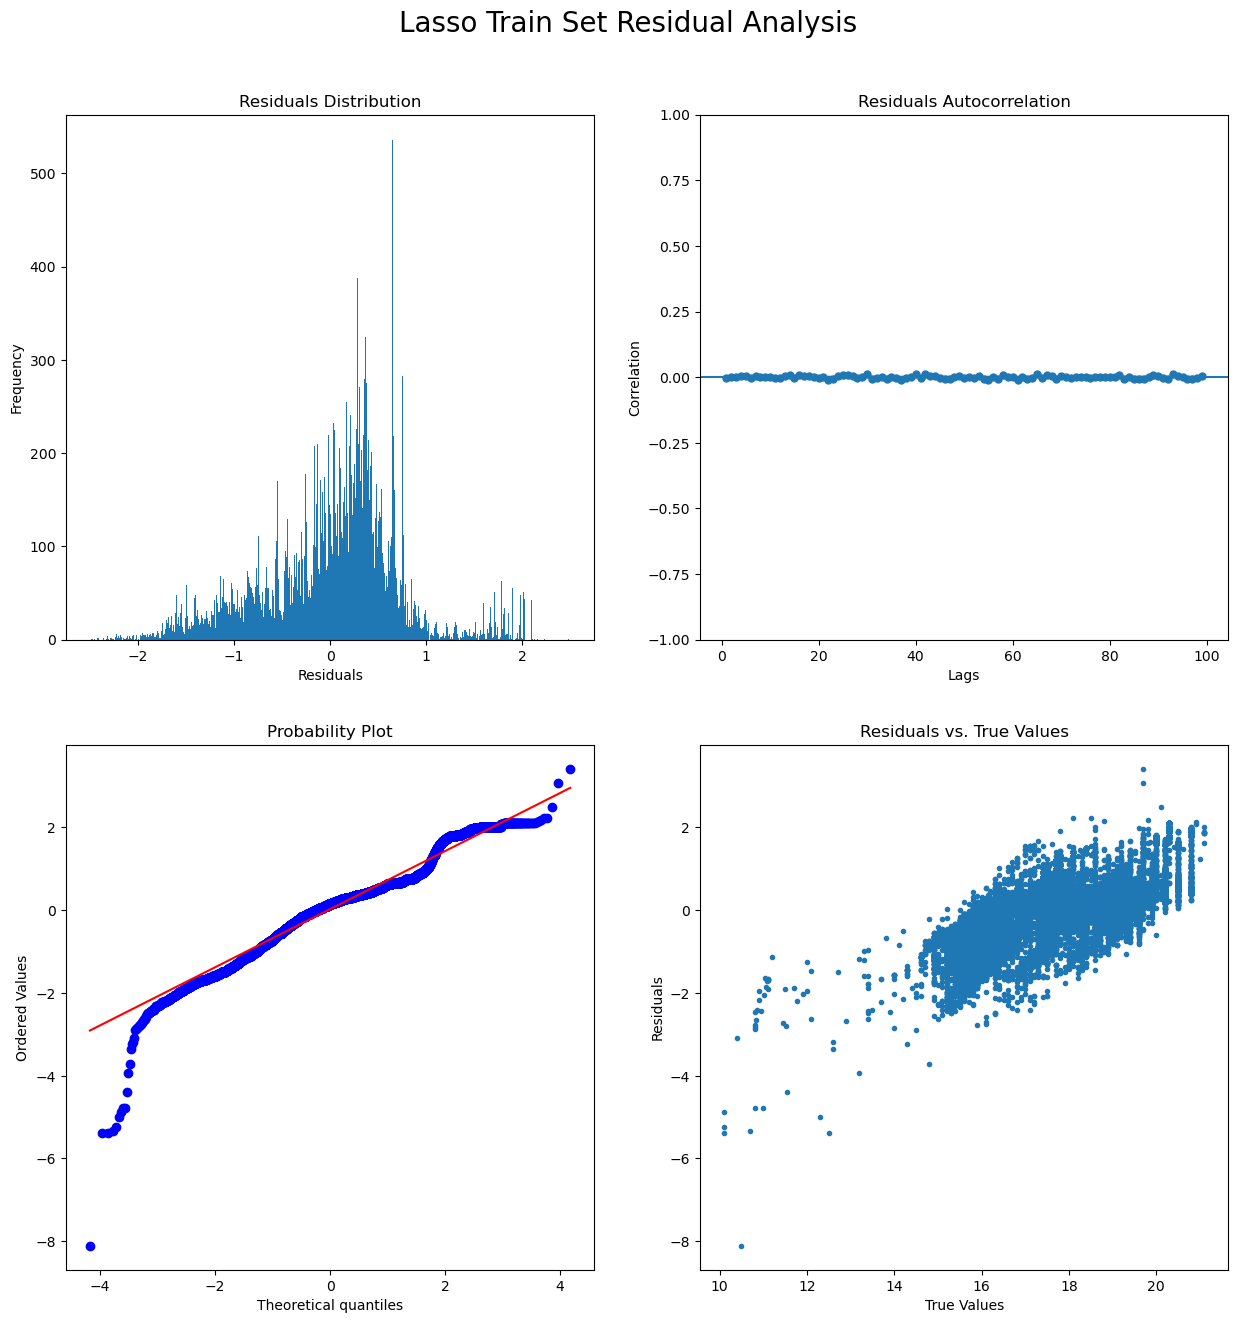

In [376]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [377]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.509527562473448
RMSE Test Set =  0.7138119937864927
MAPE Test Set =  0.03115581857854884


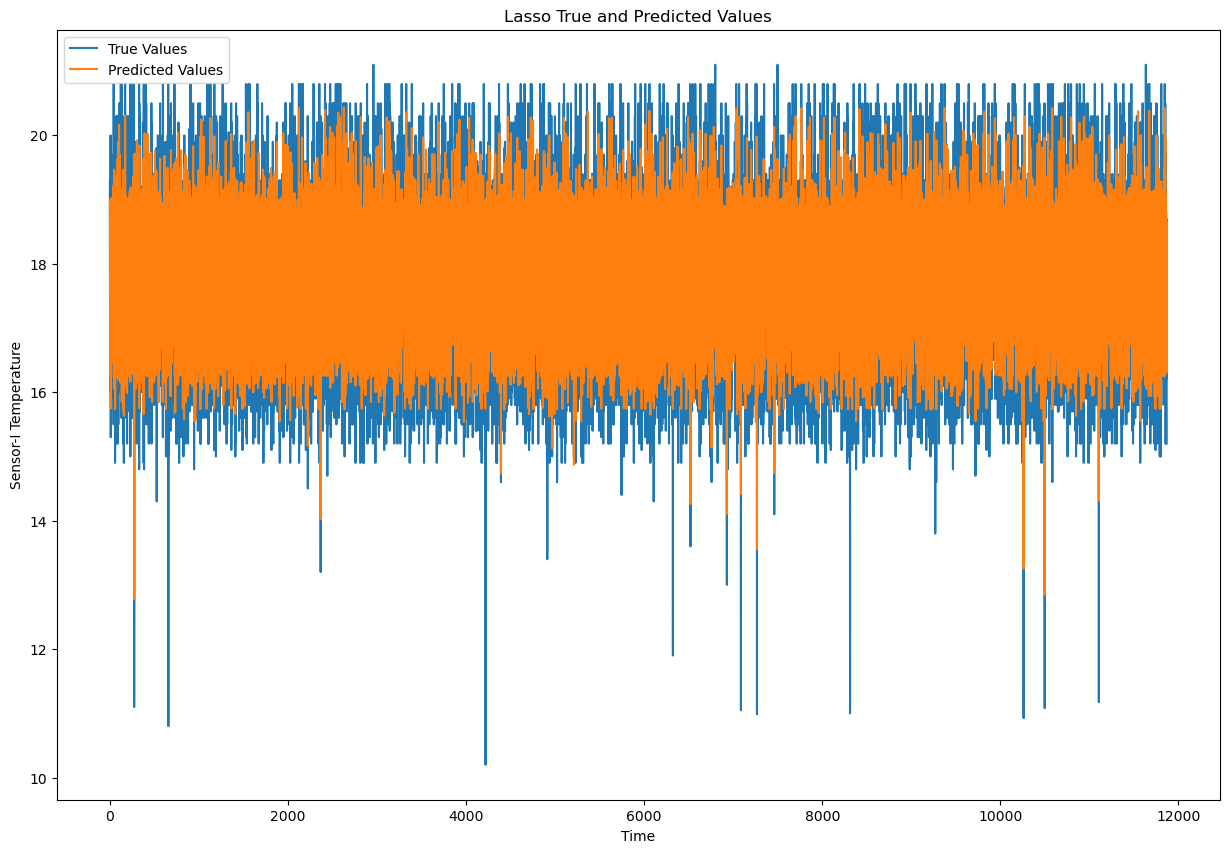

In [378]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

# Sensor-II Temperature Predictions

## OLS

In [379]:
reg_model = sm.ols(formula=formula2, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(SENSOR_II_TEMP)   R-squared:                       0.907
Model:                                OLS   Adj. R-squared:                  0.907
Method:                     Least Squares   F-statistic:                     9869.
Date:                    Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                            01:46:18   Log-Likelihood:             1.2754e+05
No. Observations:                   47473   AIC:                        -2.550e+05
Df Residuals:                       47425   BIC:                        -2.546e+05
Df Model:                              47                                         
Covariance Type:                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7617      0.005    369.172      0.000       1.752       1.771
I_KOMP1_HIZ     -7.497e-06   8.08e-06     -0.928      0.354   -2.33e-05    8.34e-06
II_KOMP1_HIZ    -6.321e-06   7.41e-06     -0.853      0.394   -2.09e-05    8.21e-06
III_KOMP1_HIZ   -1.085e-05   4.81e-06     -2.255      0.024   -2.03e-05   -1.42e-06
IV_KOMP1_HIZ    -7.709e-05   6.23e-06    -12.374      0.000   -8.93e-05   -6.49e-05
CH1_CIKIS_SIC       0.0013      0.000     13.045      0.000       0.001       0.002
CH1_GIRIS_SIC       0.0013      0.000     12.383      0.000       0.001       0.002
CH2_CIKIS_SIC       0.0012   3.34e-05     35.102      0.000       0.001       0.001
CH2_GIRIS_SIC       0.0001   8.03e-06     18.313      0.000       0.000       0.000
CH3_CIKIS_SIC      -0.0009      0.000     -8.050      0.000      -0.001      -0.001
CH3_GIRIS_SIC       0.0170      0.000     65.669      0.000       0.017       0.018
OUTLET_TEMP         0.0002      0.000      1.075      0.282      -0.000       0.000
OUTLET_HUMIDITY     0.0422      0.000    136.029      0.000       0.042       0.043
Mon                 0.0002      0.000      0.849      0.396      -0.000       0.001
Tue                 0.0022      0.000     10.328      0.000       0.002       0.003
Wed                 0.0012      0.000      5.672      0.000       0.001       0.002
Thu                 0.0002      0.000      1.108      0.268      -0.000       0.001
Fri                -0.0004      0.000     -1.877      0.060      -0.001    1.74e-05
Sat                 0.0004      0.000      2.102      0.036       3e-05       0.001
hour_0              0.0018      0.000      4.502      0.000       0.001       0.003
hour_1              0.0020      0.000      4.925      0.000       0.001       0.003
hour_2              0.0022      0.000      5.376      0.000       0.001       0.003
hour_3              0.0018      0.000      4.381      0.000       0.001       0.003
hour_4              0.0013      0.000      3.118      0.002       0.000       0.002
hour_5              0.0013      0.000      3.203      0.001       0.001       0.002
hour_6              0.0005      0.000      1.285      0.199      -0.000       0.001
hour_7             -0.0002      0.000     -0.573      0.567      -0.001       0.001
hour_8          -5.167e-05      0.000     -0.129      0.897      -0.001       0.001
hour_9              0.0015      0.000      3.611      0.000       0.001       0.002
hour_10            -0.0003      0.000     -0.673      0.501      -0.001       0.001
hour_11            -0.0014      0.000     -3.295      0.001      -0.002      -0.001
hour_12            -0.0024      0.000     -5.764      0.000      -0.003      -0.002
hour_13            -0.0046      0.000    -11.344      0.000      -0.005      -0.004
hour_14        

In [380]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.10664732232199811
RMSE Train Set =  0.326569016169627
MAPE Train Set =  0.009277135588645806


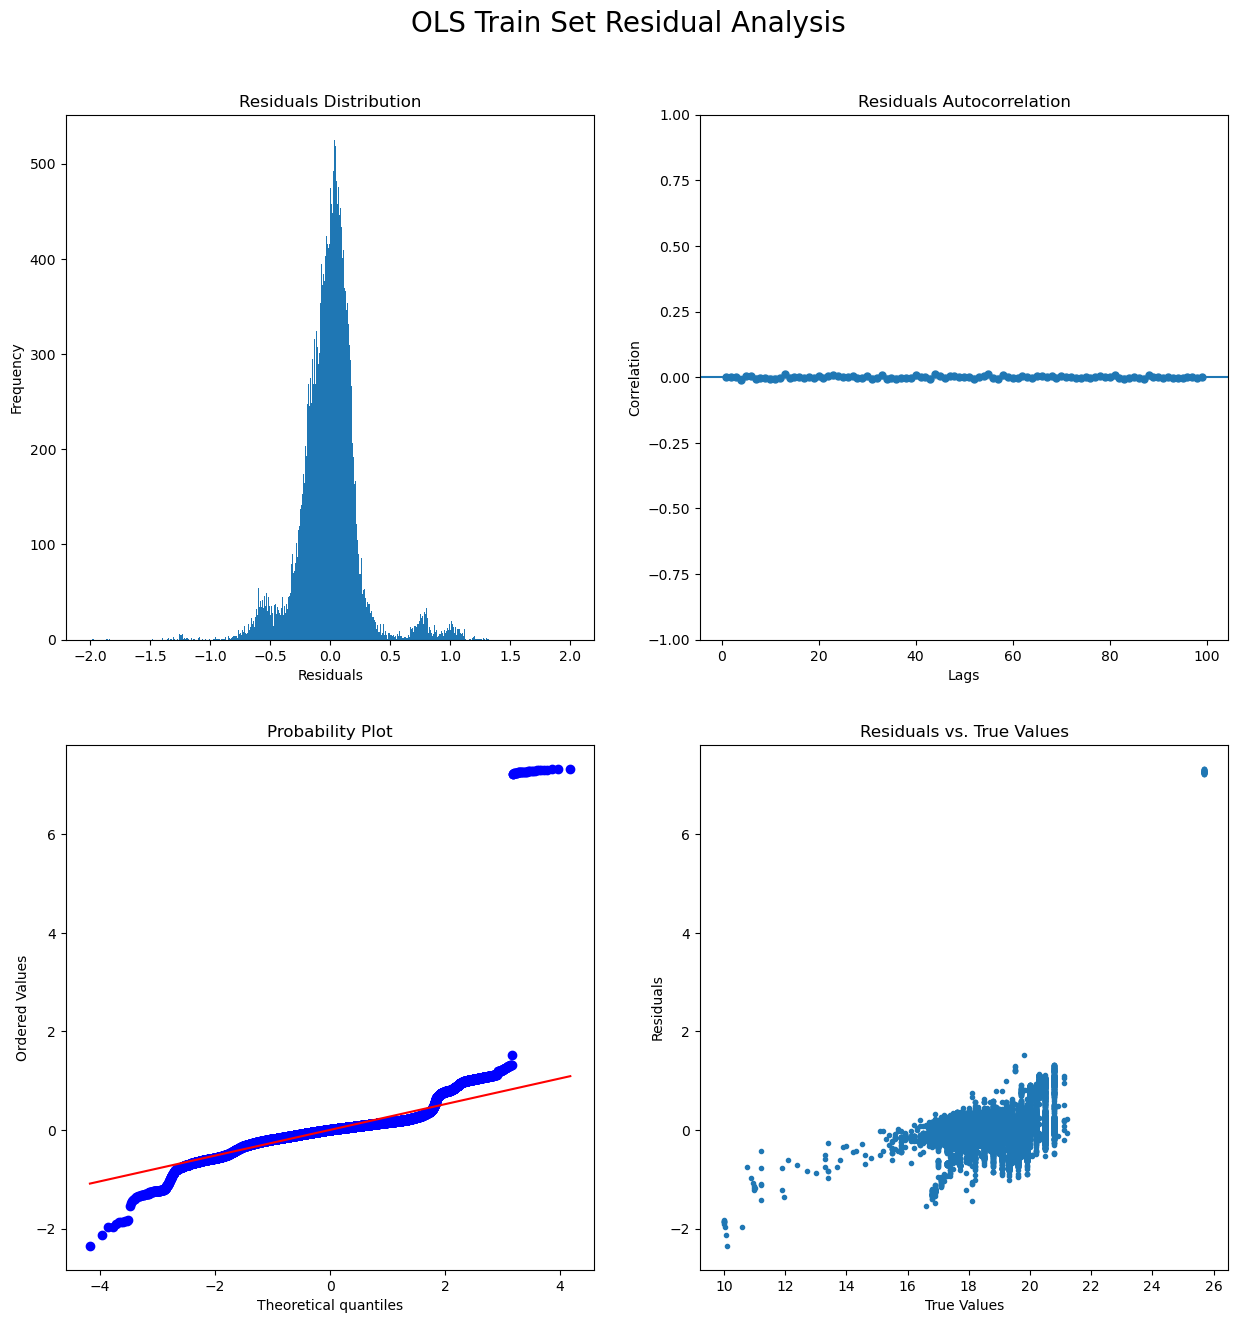

In [381]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2,2))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [382]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.10234937278353161
RMSE Test Set =  0.3199208851943424
MAPE Test Set =  0.009269806809620277


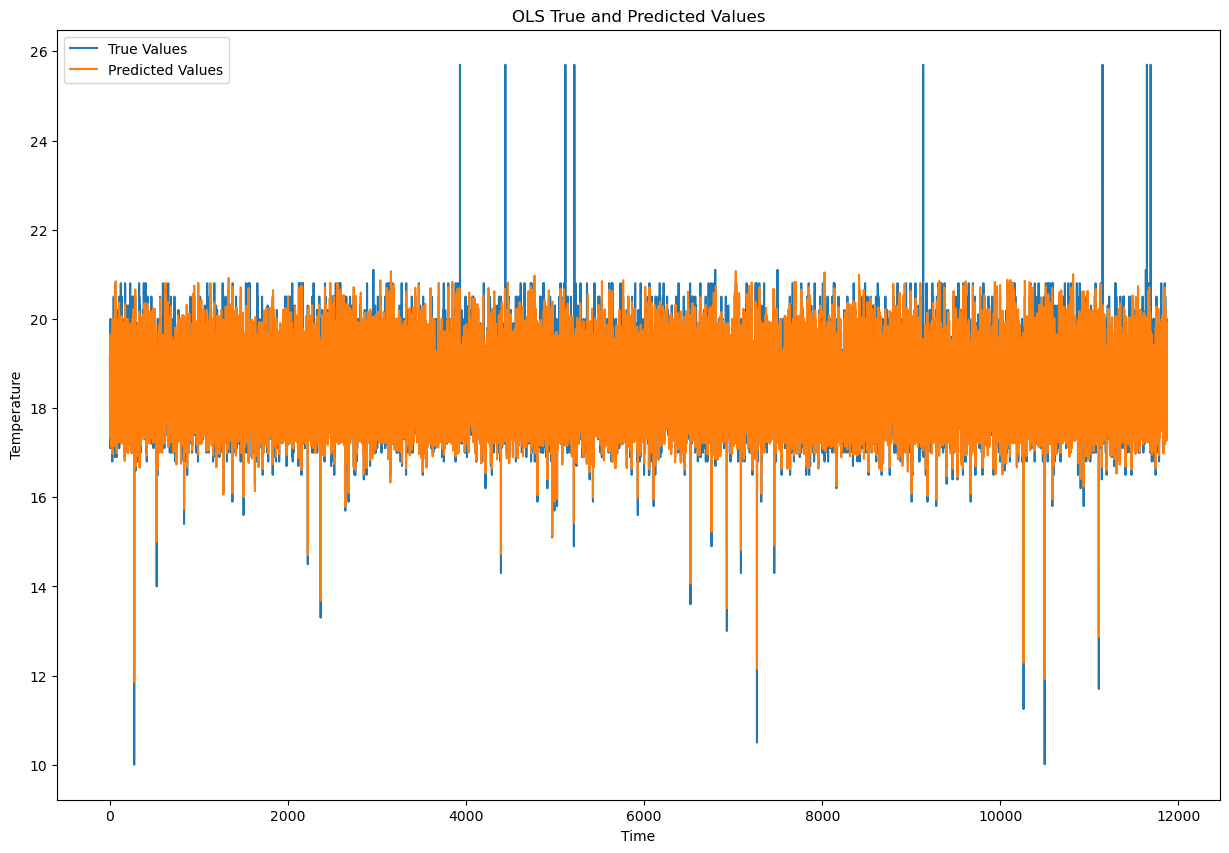

In [383]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

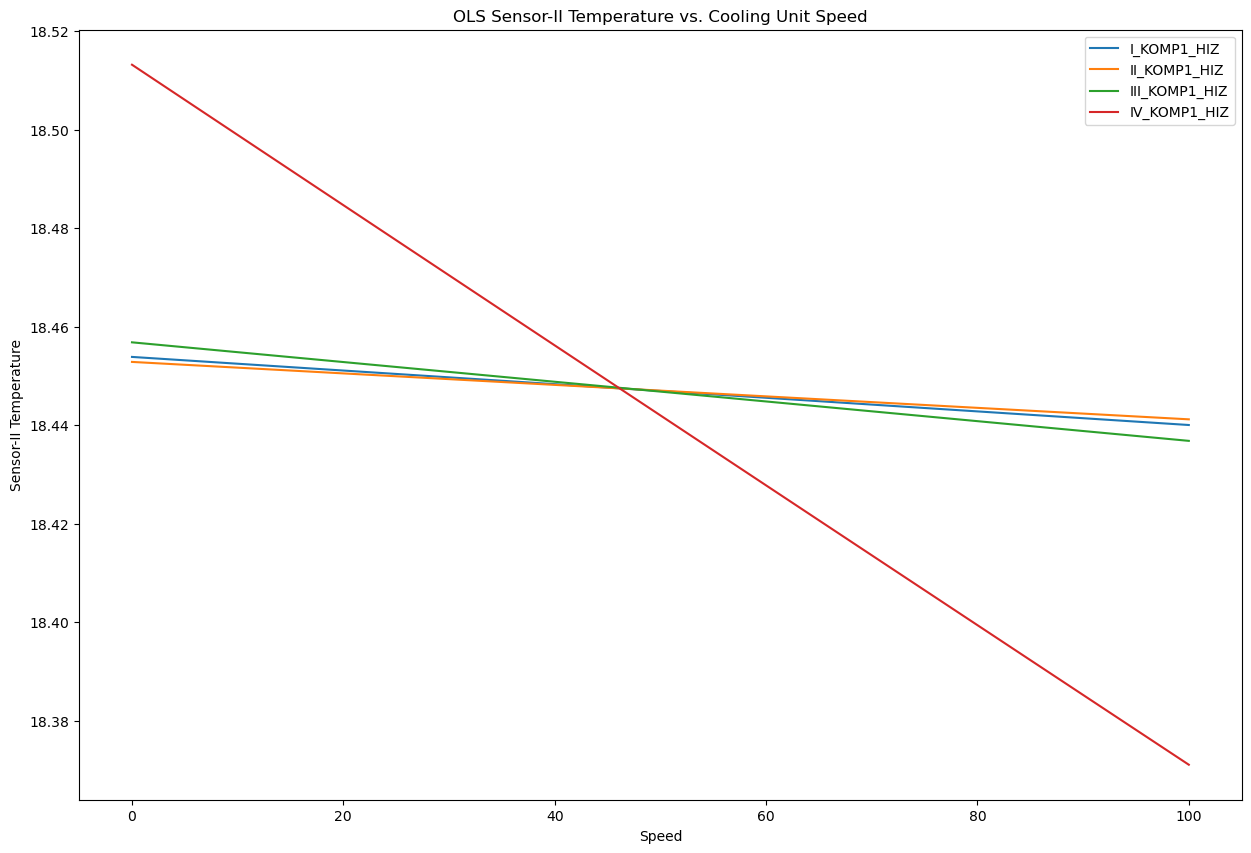

In [384]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Random Forest

In [385]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return result

In [386]:
rf_model = random_forest(max_features='sqrt')

In [387]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.001986072224198369
RMSE Train Set =  0.04456537023517665
MAPE Train Set =  0.0013544714152578748


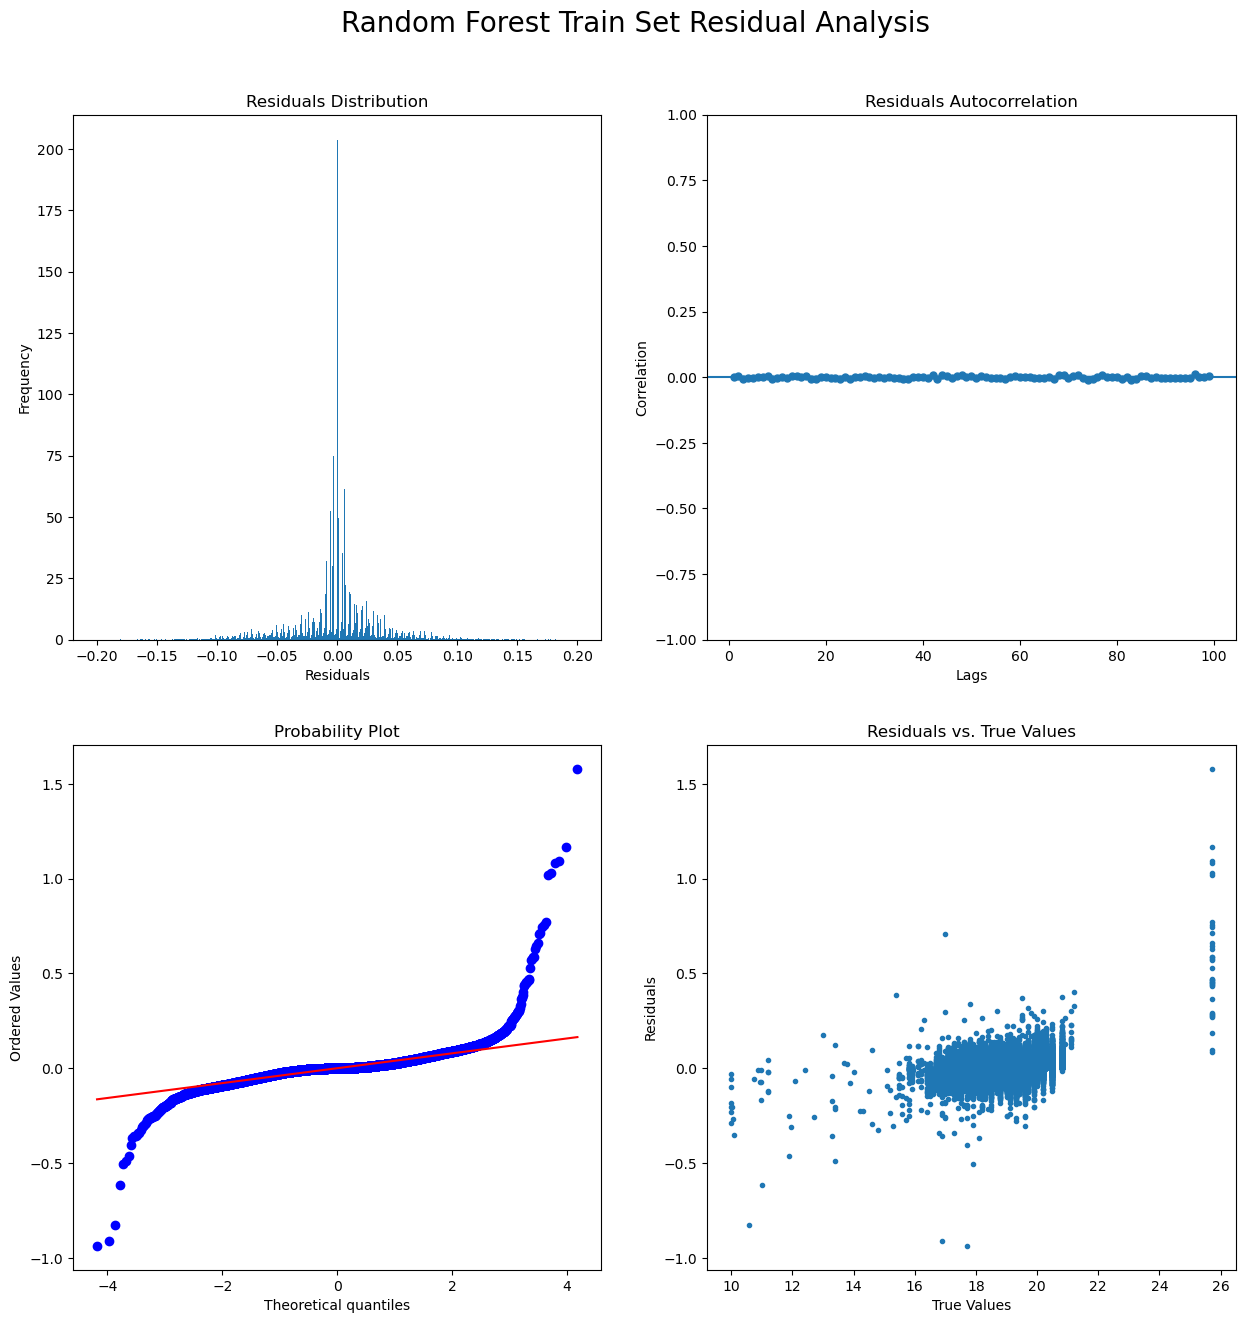

In [388]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.2,0.2), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [389]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.01191261565302903
RMSE Test Set =  0.10914492958002689
MAPE Test Set =  0.003586805638934297


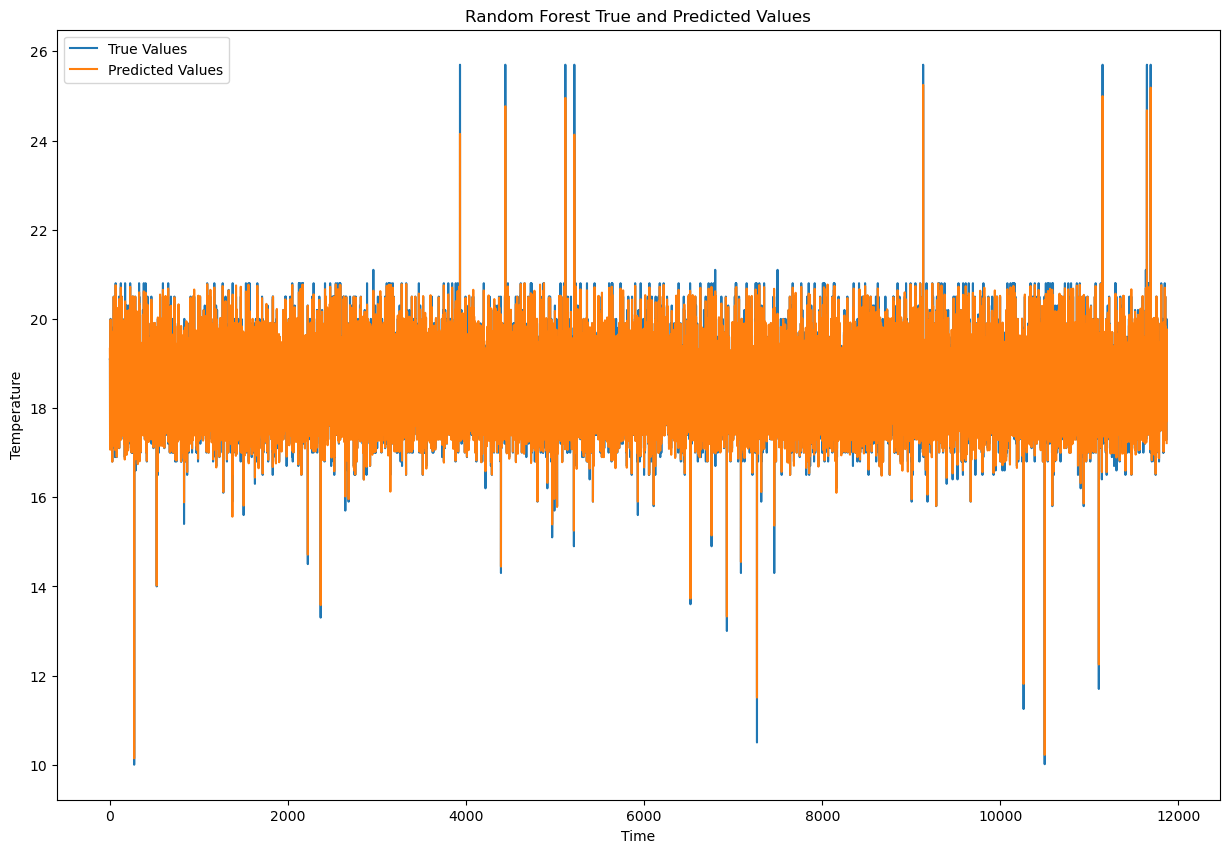

In [390]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

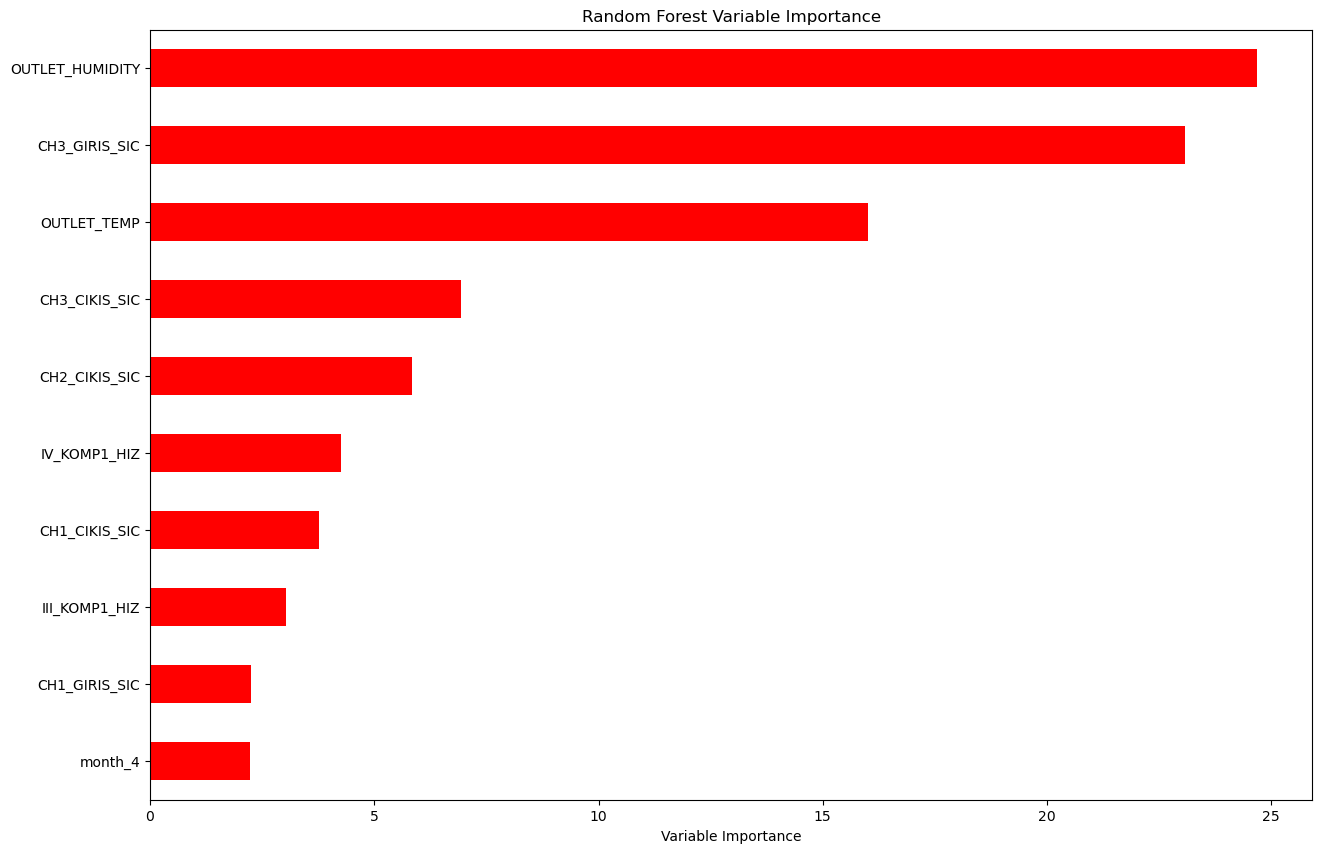

In [391]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

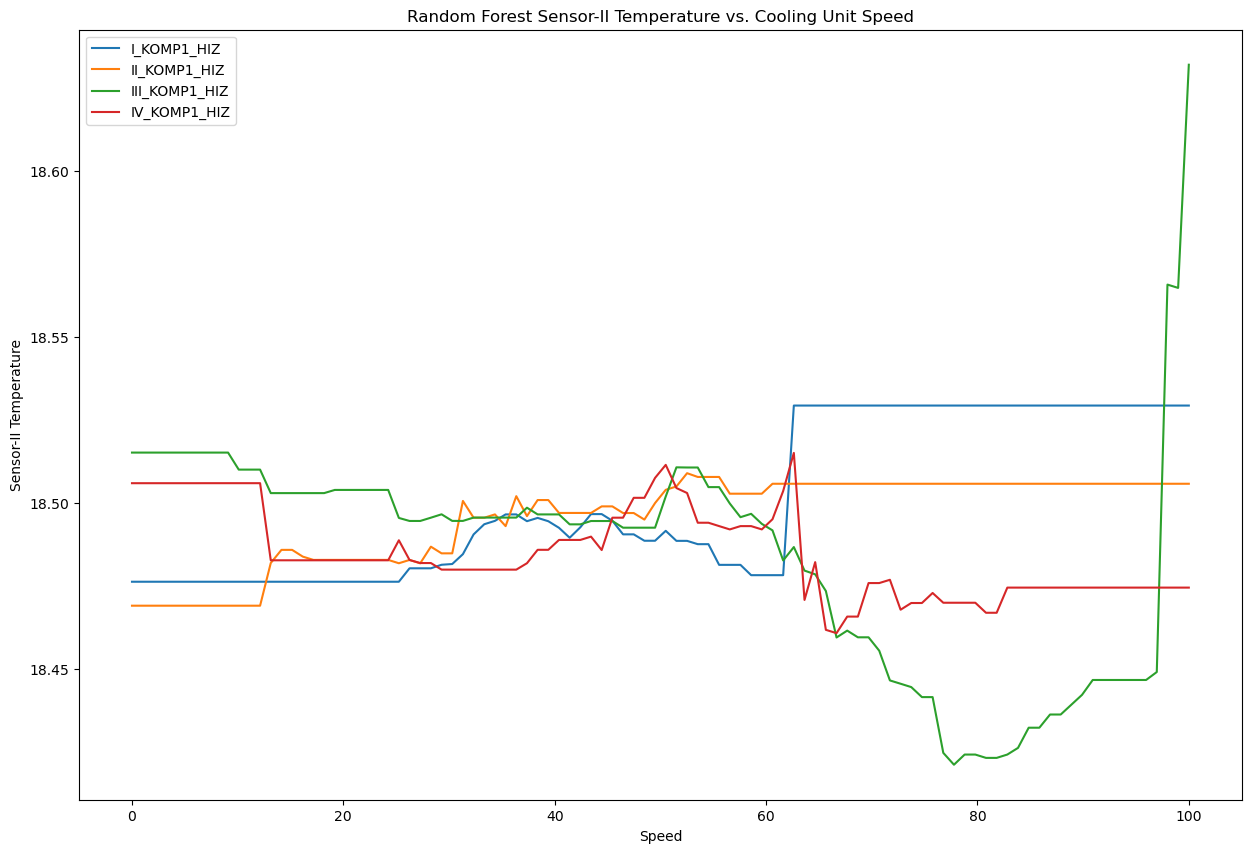

In [392]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Random Forest Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [393]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return result

In [394]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [395]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.015432297833521662
RMSE Train Set =  0.12422679998100918
MAPE Train Set =  0.0045231833463035085


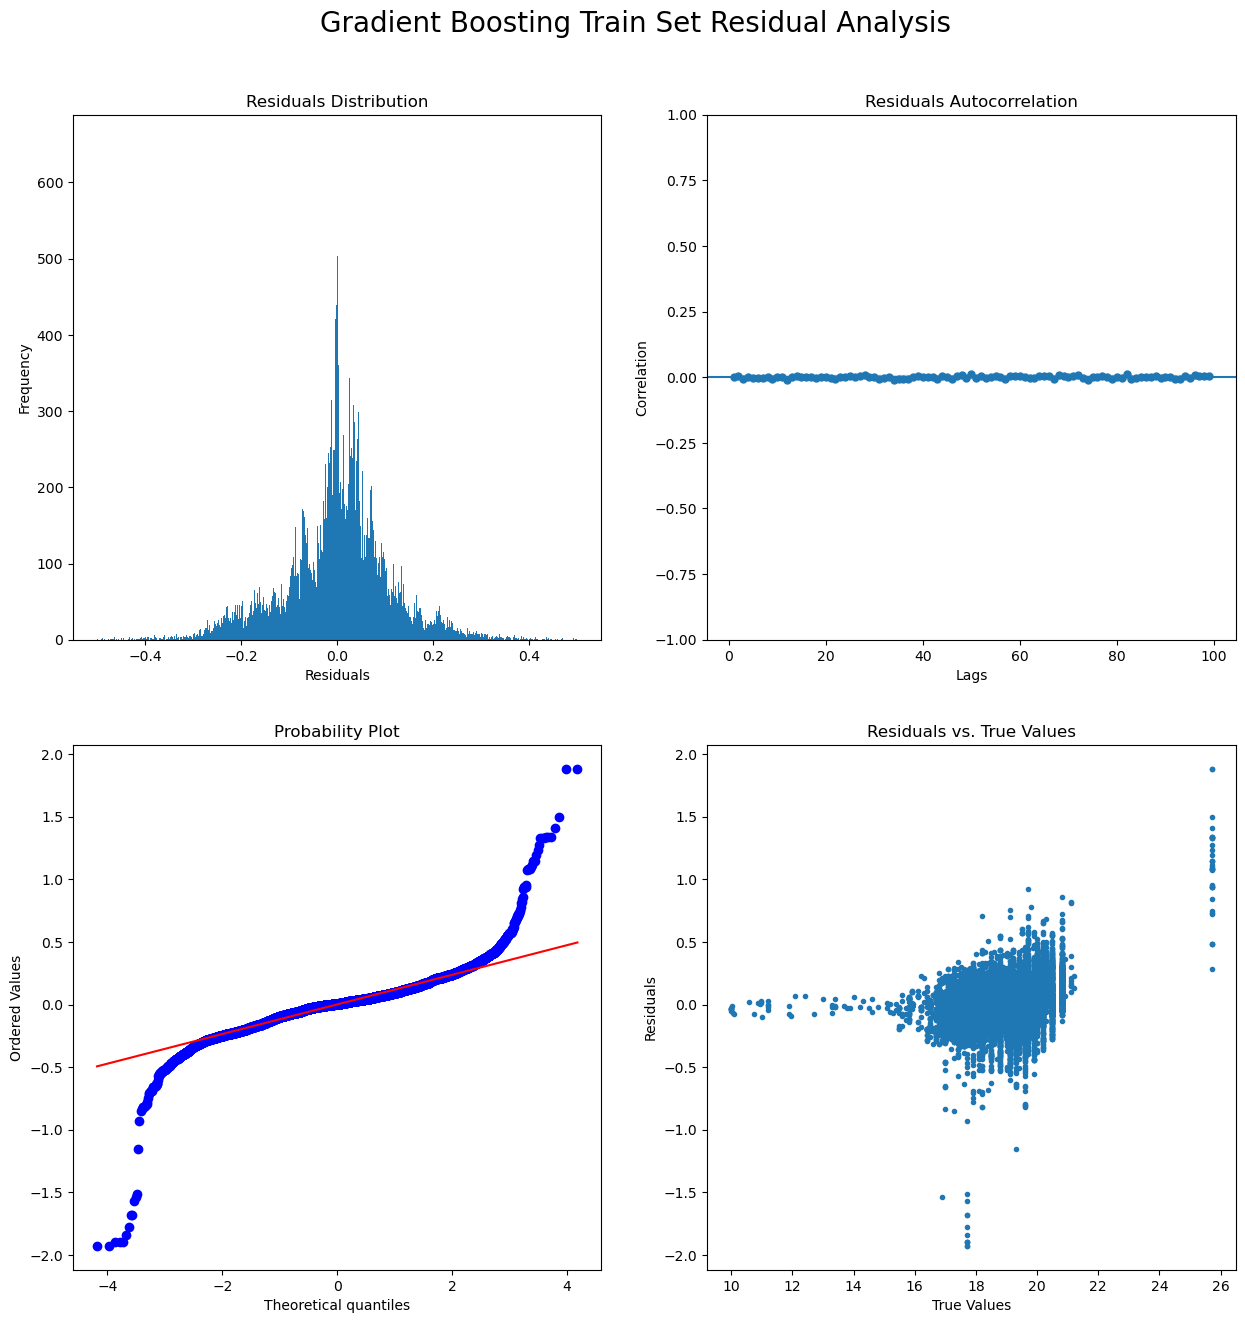

In [396]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [397]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.01664965012028078
RMSE Test Set =  0.12903352324214348
MAPE Test Set =  0.004652620942162832


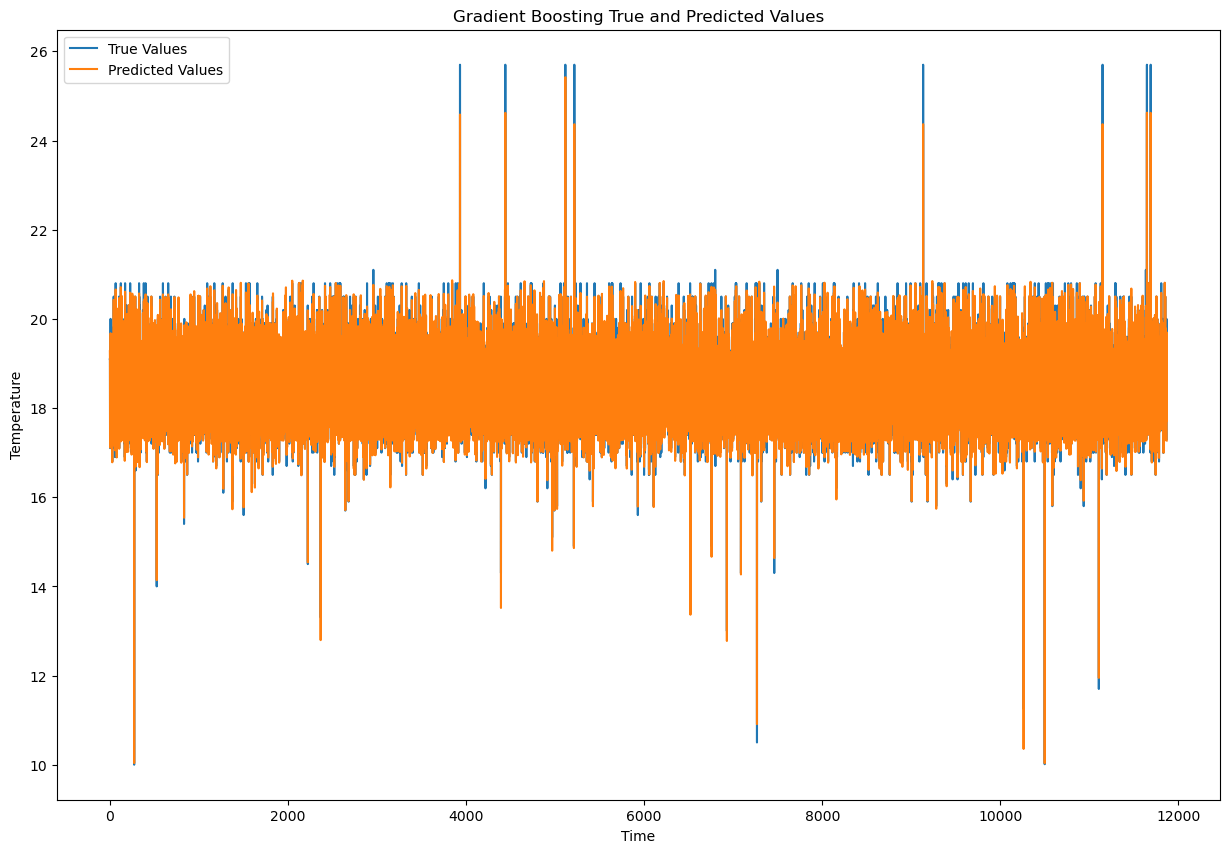

In [398]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

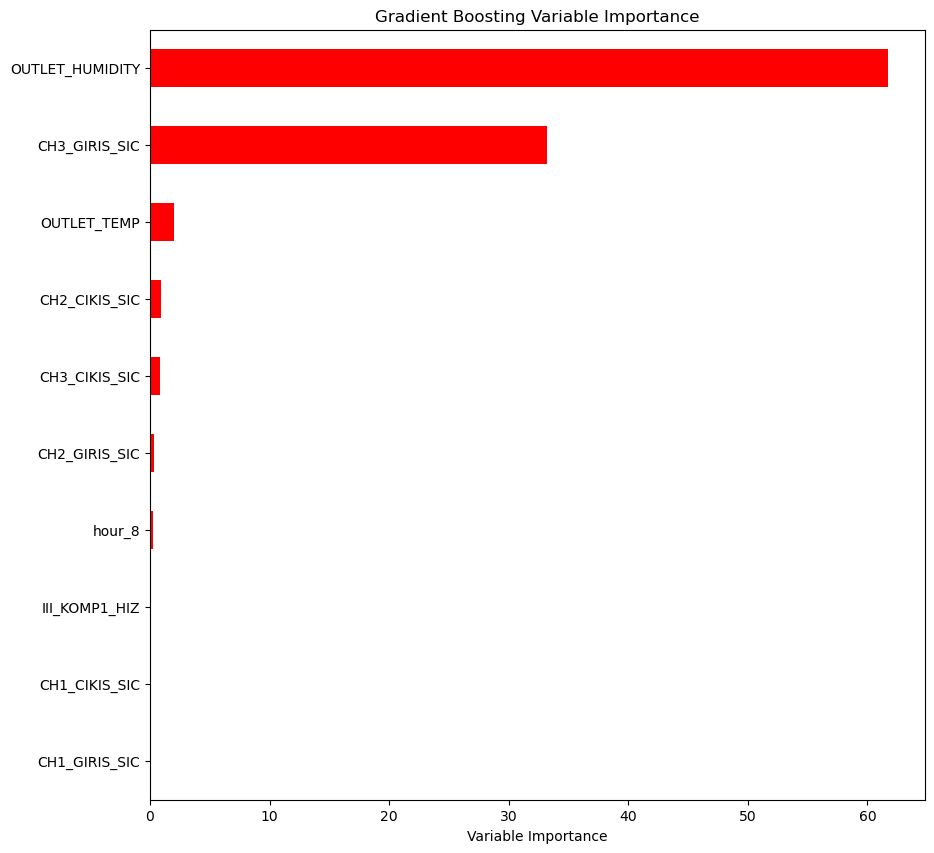

In [399]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

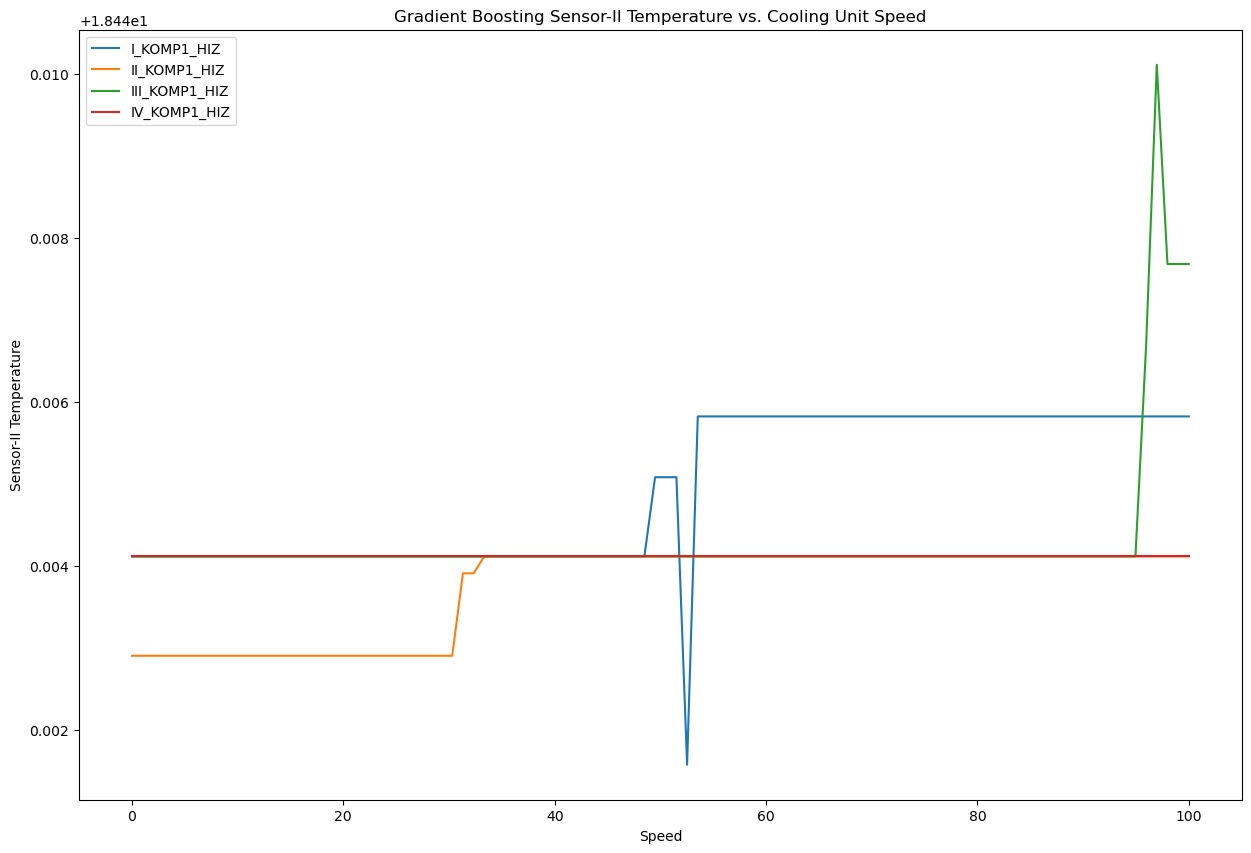

In [400]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Lasso

In [401]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [402]:
lasso_model, predictors = lasso(alpha=0.00002)

In [403]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['CH3_GIRIS_SIC', 'OUTLET_TEMP', 'OUTLET_HUMIDITY'], dtype='object')


In [404]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.12359525371148901
RMSE Test Set =  0.3515611663871438
MAPE Test Set =  0.010741175418844928


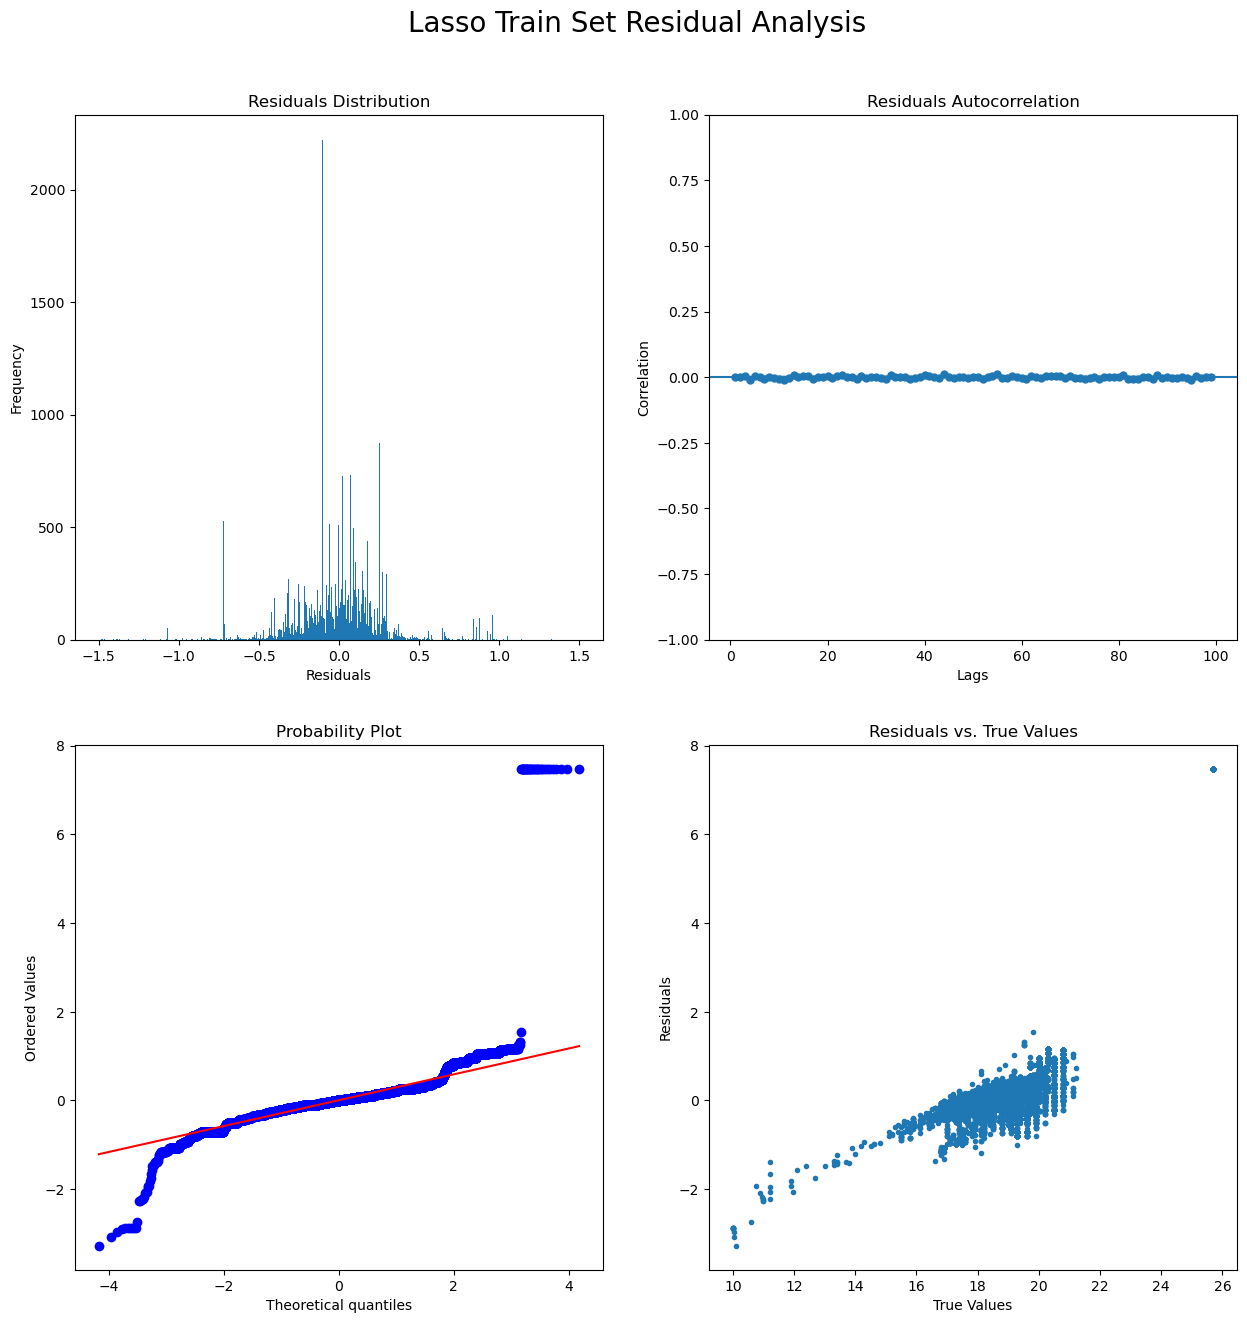

In [405]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-1.5,1.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [406]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.11799615355134456
RMSE Test Set =  0.3435056819782528
MAPE Test Set =  0.010651865875702602


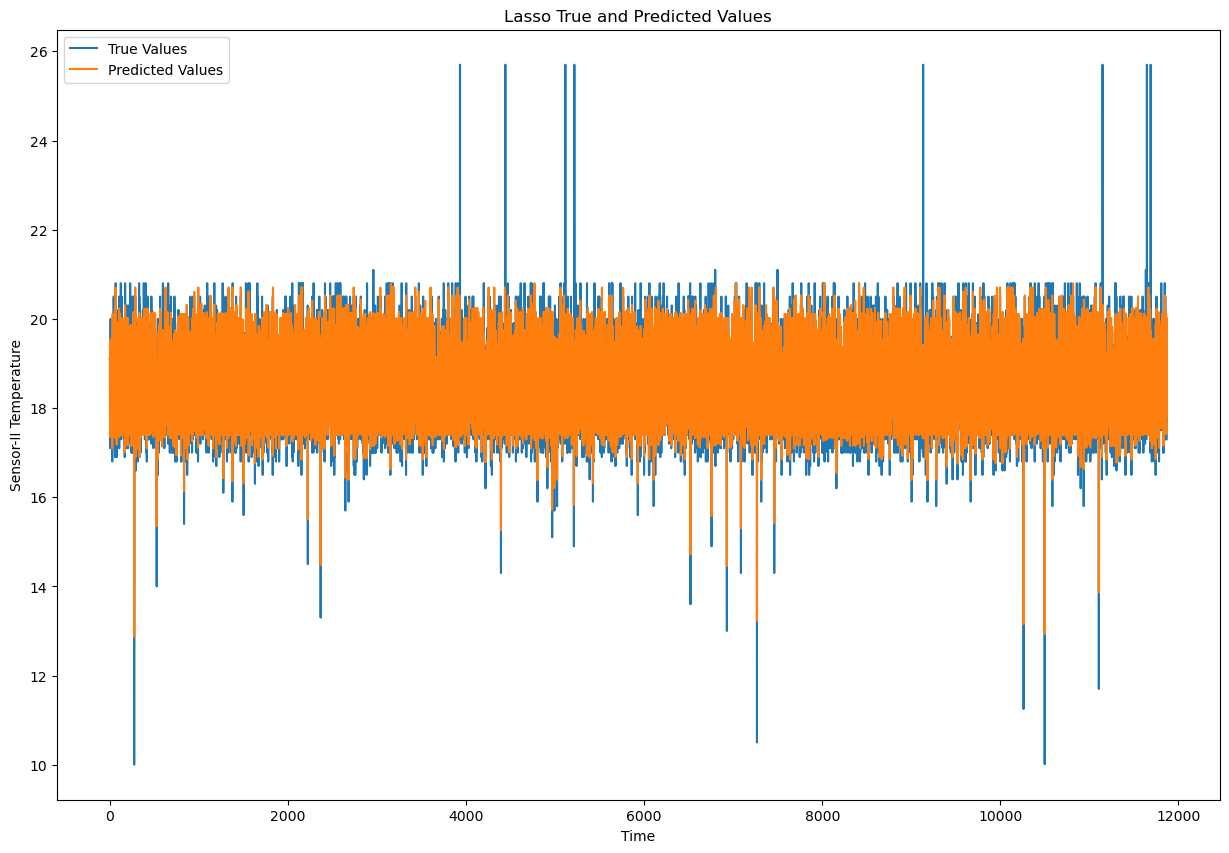

In [407]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

In [408]:
import pandas as pd
trains = [[0.0026, 0.0518, 0.0225], [0.00019, 0.0523, 0.0059], [0.0010, 0.0387, 0.0142], [0.0032,0.0566,0.0248]]
tests = [[0.0027,0.0523,0.0225],[0.0015, 0.0387, 0.0163],[0.0013, 0.03613, 0.01514], [0.0032,0.0571, 0.0250]]

train_values = {
    'MSE': [trains[i][0] for i in range(4)],
    'Train RMSE': [trains[i][1] for i in range(4)],
    'Train MAPE': [trains[i][2] for i in range(4)],
}

test_values = {
    'MSE': [tests[i][0] for i in range(4)],
    'Test RMSE': [tests[i][1] for i in range(4)],
    'Test MAPE': [tests[i][2] for i in range(4)],
}
model_info = pd.DataFrame({
    'Model': ['Regression', 'Random Forest', 'Gradient Boosting', 'Lasso'],
    'Train MSE': [train[0] for train in trains],
    'Train RMSE': [train[1] for train in trains],
    'Train MAPE': [train[2] for train in trains],
    'Test MSE': [test[0] for test in tests],
    'Test RMSE': [test[1] for test in tests],
    'Test MAPE': [test[2] for test in tests],
    'Parameters': ["None", "max_features = 'sqrt'", "learning rate = 0.1, depth = 5", "Alpha = 0.0001"]
})
model_info.reset_index(drop=True, inplace=True)
model_info = model_info.loc[:,["Model","Parameters", "Train MSE", "Train RMSE", "Train MAPE", "Test MSE", "Test RMSE", "Test MAPE"]]
model_info.to_excel("model_info.xlsx", index=False)
